In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Load Data

In [2]:
df = pd.read_csv('minimal_merlin_data.csv') 

In [3]:
df = df.replace({True: 1, False: 0})

In [4]:
# Filter the DataFrame to include only neuraxial catheter (ie, epidural + CSE + intrathecal) or epidural-only catheter procedures
neuraxial_catheter_df = df[df['is_neuraxial_catheter'] == 1]
epidural_df = df[(df['true_procedure_type_incl_dpe'] == 'epidural') | (df['true_procedure_type_incl_dpe'] == 'dpe')]

# Describe Dataframe

There are 134446 total rows, of which a fraction have NaN true_procedure_type.

Every row receives a value for all Boolean variables: thus if no value is present, they become False. Furthermore, NaN procedures become False is_neuraxial_catheter and failed_catheter.

is_neuraxial_catheter includes epidurals + CSEs + intrathecals

failed_catheter is applied to BOTH neuraxial_catheters (which may be coded True or False for failure) and also to all procedures that are not neuraxial_catheters (will always be coded False).

In [5]:
df.shape

(134997, 37)

In [6]:
def describe_dataframe(df):
    """
    For each column in df:
      - If dtype is object or int64 or bool, list each unique value and its counts.
      - If dtype is float64, display min, Q1, median, Q3, and max.
      - Otherwise, handle accordingly (datetime, etc.).
    """
    for col in df.columns:
        col_type = df[col].dtype

        print(f"Column: {col}")
        print(f"  Data Type: {col_type}")

        if col == "anes_procedure_encounter_id_2273":
            print("  (Encounter IDs – no numeric summary or value counts shown.)")

        elif col_type == 'object' or col_type == 'int64' or col_type == 'bool':
            # Show unique values and their counts
            value_counts = df[col].value_counts(dropna=False)
            print("  Value counts:")
            for val, count in value_counts.items():
                print(f"    {val}: {count}")

        elif col_type == 'float64':
            # Show min, Q1 (25%), median (50%), Q3 (75%), and max
            desc = df[col].describe(percentiles=[0.25, 0.5, 0.75])
            na_count = df[col].isna().sum()
            print("  Summary stats:")
            print(f"    NaN:    {na_count}")
            print(f"    Min:    {desc['min']}")
            print(f"    Q1:     {desc['25%']}")
            print(f"    Median: {desc['50%']}")
            print(f"    Q3:     {desc['75%']}")
            print(f"    Max:    {desc['max']}")

        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            # Example handling for datetime columns
            print("  (Datetime column – no numeric summary or value counts shown.)")

        else:
            # Handle any other data types as needed
            print("  (No specific handling implemented for this data type.)")

        print("-" * 50)

describe_dataframe(df)


Column: anes_procedure_encounter_id_2273
  Data Type: int64
  (Encounter IDs – no numeric summary or value counts shown.)
--------------------------------------------------
Column: gestational_age_2052
  Data Type: float64
  Summary stats:
    NaN:    19
    Min:    87.0
    Q1:     268.0
    Median: 275.0
    Q3:     281.0
    Max:    308.0
--------------------------------------------------
Column: delivery_site_2188
  Data Type: object
  Value counts:
    bwh: 56893
    mgh: 30653
    nwh: 29230
    slm: 8075
    wdh: 5896
    cdh: 2678
    nch: 798
    mvh: 772
    nan: 2
--------------------------------------------------
Column: baby_weight_2196
  Data Type: float64
  Summary stats:
    NaN:    1083
    Min:    0.0002834952
    Q1:     2.999379216
    Median: 3.3398569512
    Q3:     3.6650259456
    Max:    7.1698771032
--------------------------------------------------
Column: rom_thru_delivery_hours
  Data Type: float64
  Summary stats:
    NaN:    15160
    Min:    0.0
    Q1: 

In [7]:
def describe_as_tables(df):
    # Separate columns by dtype
    categorical_cols = []
    numeric_cols = []

    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'int64' or df[col].dtype == 'bool':
            categorical_cols.append(col)
        elif df[col].dtype == 'float64':
            numeric_cols.append(col)
        else:
            # skip or handle datetime, etc. if desired
            pass

    # --- Build table for categorical variables ---
    cat_data = {}
    for col in categorical_cols:
        # Get value counts (including NaN as a separate category)
        vc = df[col].value_counts(dropna=False)
        # Convert value counts to a dict, or a formatted string
        vc_str = ", ".join(f"{val}: {count}" for val, count in vc.items())
        cat_data[col] = {
            'value_counts': vc_str
        }
    cat_df = pd.DataFrame(cat_data).T  # Transpose so rows = columns, col = 'value_counts'

    # --- Build table for numeric variables ---
    num_data = {}
    for col in numeric_cols:
        desc = df[col].describe(percentiles=[0.25, 0.5, 0.75])
        na_count = df[col].isna().sum()
        num_data[col] = {
            'count': desc['count'],
            'count_nan': na_count,
            'min': desc['min'],
            'Q1': desc['25%'],
            'median': desc['50%'],
            'Q3': desc['75%'],
            'max': desc['max']
        }
    num_df = pd.DataFrame(num_data).T  # Transpose so rows = columns

    return cat_df, num_df

cat_table, num_table = describe_as_tables(df)


In [9]:
cat_table

,value_counts
anes_procedure_encounter_id_2273,"3168368171: 5, 3229266208: 5, 3249812793: 5, 3..."
delivery_site_2188,"bwh: 56893, mgh: 30653, nwh: 29230, slm: 8075,..."
fetal_presentation_category_2243,"cephalic: 116565, nan: 8989, breech: 6475, com..."
fetal_presentation_subcategory_2244,"vertex: 116411, nan: 15406, compound: 2488, tr..."
fetal_presentation_position_2247,"nan: 69014, anterior: 56679, posterior: 6701, ..."
is_neuraxial_catheter,"1: 106750, 0: 28247"
failed_catheter,"0: 129216, 1: 5781"
highly_experienced_anesthesiologist,"no: 61156, yes: 45464, none: 28377"
highly_experienced_resident,"none: 62242, no: 45775, yes: 26980"
moderately_experienced_anesthesiologist,"yes: 85089, none: 28377, no: 21531"


In [10]:
num_table

,count,count_nan,min,Q1,median,Q3,max
gestational_age_2052,134978.0,19.0,87.000000,268.000000,275.000000,281.000000,308.000000
baby_weight_2196,133914.0,1083.0,0.000283,2.999379,3.339857,3.665026,7.169877
rom_thru_delivery_hours,119837.0,15160.0,0.000000,2.050000,6.116667,12.775833,711.816667
bmi_end_pregnancy_2044,130784.0,4213.0,5.800000,27.100000,30.200000,34.300000,69.900000
maternal_weight_end_pregnancy_2045,132233.0,2764.0,0.089018,70.760410,79.832257,91.172066,217.724338
bmi_before_pregnancy_2161,95602.0,39395.0,6.660000,22.100000,25.000000,29.400000,67.700000
gravidity_2047,94095.0,40902.0,0.000000,1.000000,2.000000,3.000000,16.000000
parity_2048,82097.0,52900.0,0.000000,0.000000,1.000000,1.000000,12.000000
lor_depth,102649.0,32348.0,0.000000,4.800000,5.000000,6.000000,18.000000
current_resident_catheter_count,72755.0,62242.0,0.000000,15.000000,36.000000,66.000000,329.000000


# Data Visualization

## Procedure Types

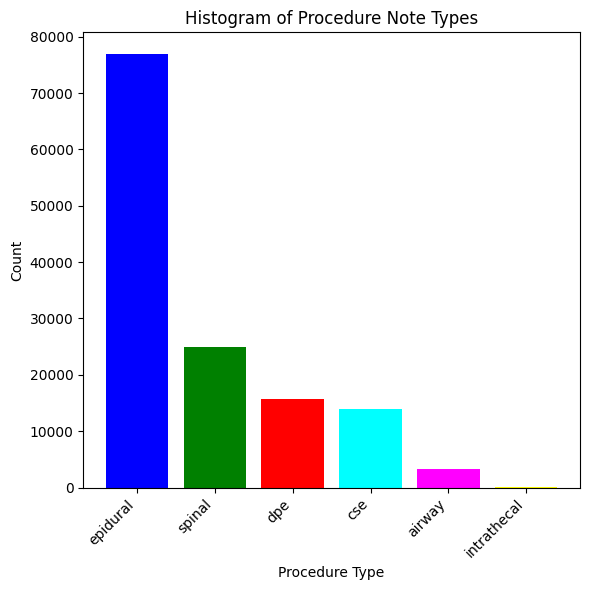

In [11]:
# prompt: make a histogram of procedure note types using different colors

# Assuming 'procedure_type' column exists in your DataFrame 'df'
procedure_type_counts = df['true_procedure_type_incl_dpe'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(procedure_type_counts.index, procedure_type_counts.values, color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange'])
plt.xlabel('Procedure Type')
plt.ylabel('Count')
plt.title('Histogram of Procedure Note Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


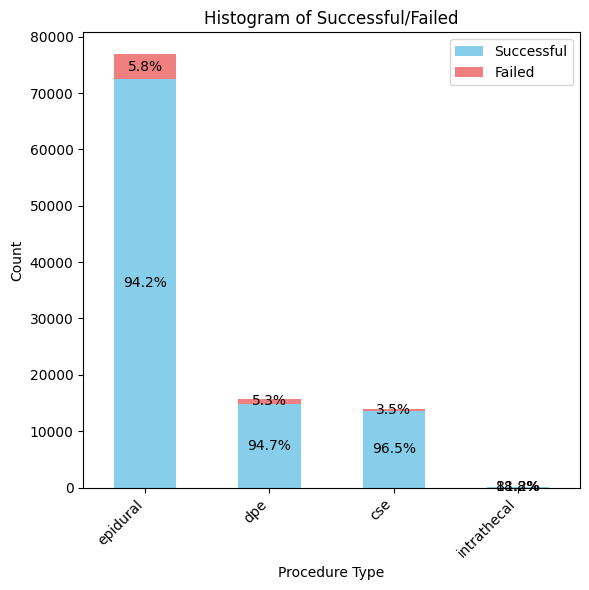

In [12]:
# Histogram of successes/failures

# Group by procedure type and whether it has subsequent anesthesia
procedure_counts = pd.crosstab(neuraxial_catheter_df['true_procedure_type_incl_dpe'], neuraxial_catheter_df['failed_catheter'])

# Sort the bars in descending order based on the total count of each procedure type
procedure_counts = procedure_counts.sort_values(by=0, ascending=False)

# Create a stacked bar chart
ax = procedure_counts.plot(kind='bar', stacked=True, figsize=(6
, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
  width = p.get_width()
  height = p.get_height()
  x, y = p.get_xy()
  ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Procedure Type')
plt.ylabel('Count')
plt.title('Histogram of Successful/Failed')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()


In [13]:
# Display the table with the same information
print("Table of Neuraxial Catheter Procedures by Success/Failure:")
print(procedure_counts)


Table of Neuraxial Catheter Procedures by Success/Failure:
failed_catheter                   0     1
true_procedure_type_incl_dpe             
epidural                      72482  4446
dpe                           14885   827
cse                           13498   484
intrathecal                     104    24


## Anesthesiologist Experience

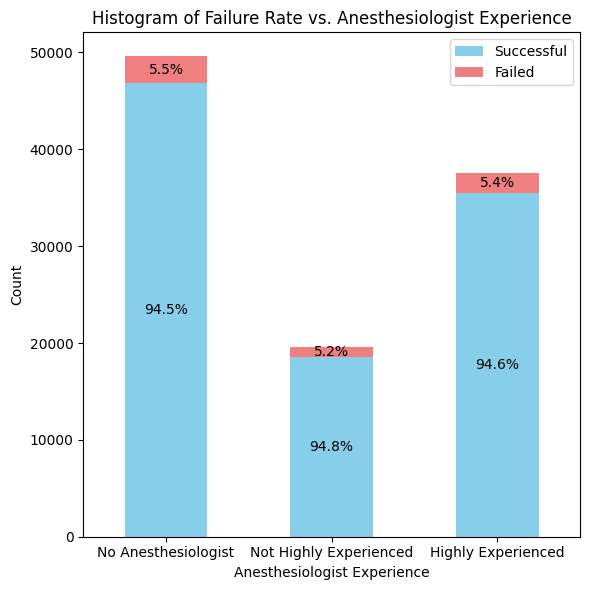

Table of Failure Rate vs. Anesthesiologist Experience:


failed_catheter,0,1
highly_experienced_anesthesiologist,,
no,46860,2735
none,18601,1023
yes,35508,2023


In [14]:
# prompt: Create a similar histogram for failure rate vs highly experienced anesthesiologist

# Group by 'highly_experienced_anesthesiologist' and 'failed_catheter'
experience_failure_counts = pd.crosstab(neuraxial_catheter_df['highly_experienced_anesthesiologist'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Anesthesiologist Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Anesthesiologist Experience')
plt.xticks(rotation=0, ha='center', ticks=[0,1,2], labels=['No Anesthesiologist','Not Highly Experienced', 'Highly Experienced'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Anesthesiologist Experience:")
experience_failure_counts

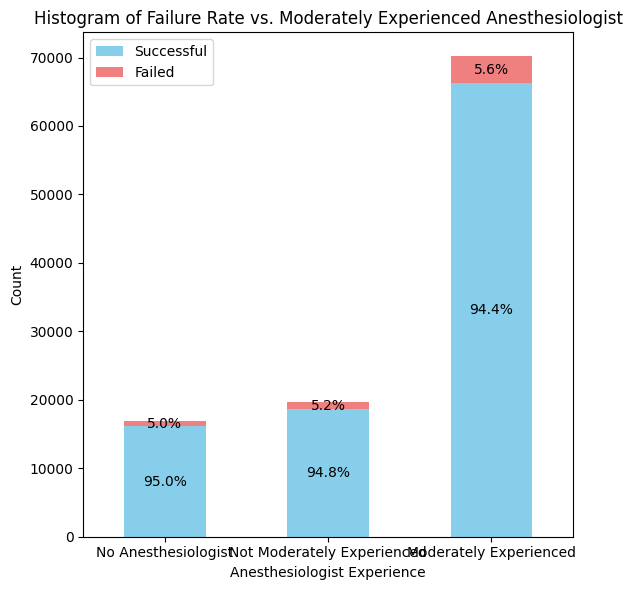

Table of Failure Rate vs. Moderately Experienced Anesthesiologist:


failed_catheter,0,1
moderately_experienced_anesthesiologist,,
no,16112,841
none,18601,1023
yes,66256,3917


In [15]:
# prompt: create a similar histogram for failure rate vs moderately experienced anesthesiologist

# Group by 'moderately_experienced_anesthesiologist' and 'failed_catheter'
experience_failure_counts = pd.crosstab(neuraxial_catheter_df['moderately_experienced_anesthesiologist'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Anesthesiologist Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Moderately Experienced Anesthesiologist')
plt.xticks(rotation=0, ha='center', ticks=[0,1,2], labels=['No Anesthesiologist','Not Moderately Experienced', 'Moderately Experienced'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Moderately Experienced Anesthesiologist:")
experience_failure_counts

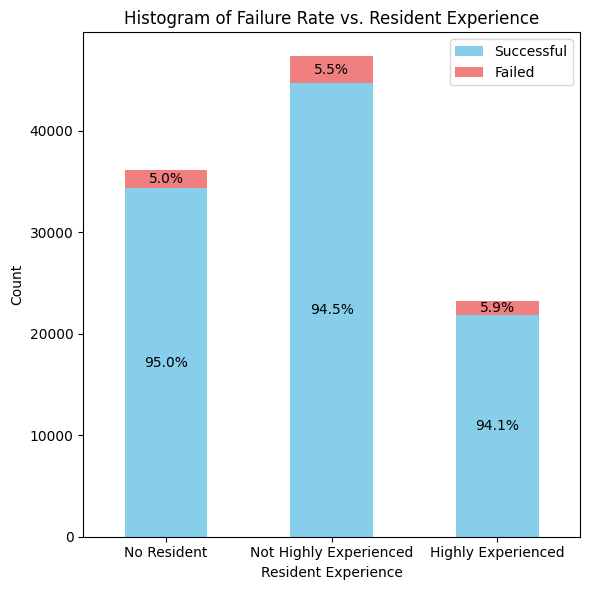

Table of Failure Rate vs. Resident Experience:


failed_catheter,0,1
highly_experienced_resident,,
no,34350,1809
none,44751,2605
yes,21868,1367


In [16]:
# prompt: Create a similar histogram for failure rate vs highly experienced resident

# Group by 'highly_experienced_resident' and 'failed_catheter'
experience_failure_counts = pd.crosstab(neuraxial_catheter_df['highly_experienced_resident'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Resident Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Resident Experience')
plt.xticks(rotation=0, ha='center', ticks=[0,1,2], labels=['No Resident','Not Highly Experienced', 'Highly Experienced'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Resident Experience:")
experience_failure_counts

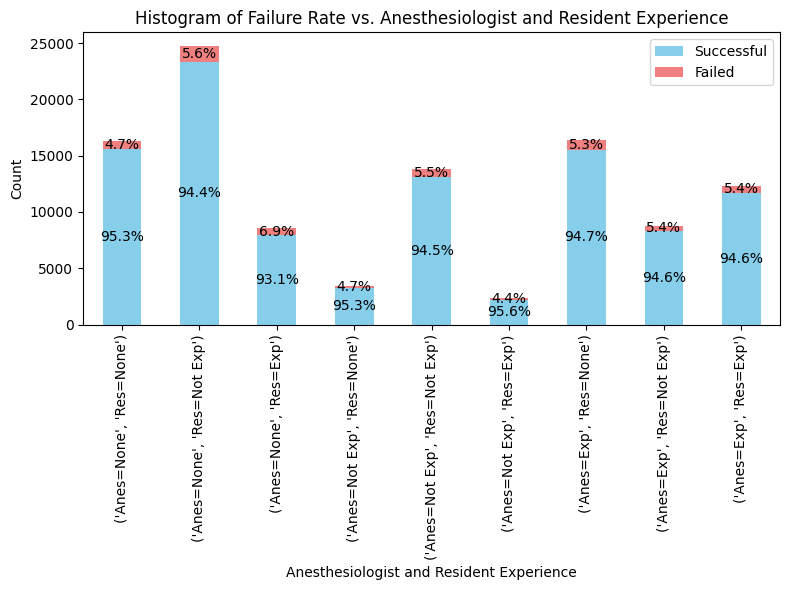

Table of Failure Rate vs. Anesthesiologist and Resident Experience:


failed_catheter                                                      0     1
highly_experienced_anesthesiologist highly_experienced_resident             
no                                  no                           15552   771
                                    none                         23346  1372
                                    yes                           7962   592
none                                no                            3280   163
                                    none                         13095   757
                                    yes                           2226   103
yes                                 no                           15518   875
                                    none                          8310   476
                                    yes                          11680   672

In [17]:
# prompt: Create a similar histogram but look at all combinations of resident and anesthesiologist experience. Make the x-axis labels vertical.

# Group by 'highly_experienced_anesthesiologist', 'highly_experienced_resident', and 'failed_catheter'
experience_failure_counts = pd.crosstab([neuraxial_catheter_df['highly_experienced_anesthesiologist'], neuraxial_catheter_df['highly_experienced_resident']], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = experience_failure_counts.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Anesthesiologist and Resident Experience')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Anesthesiologist and Resident Experience')


# Customize x-axis labels
import itertools
anesth_levels = ["Anes=None", "Anes=Not Exp", "Anes=Exp"]
resident_levels = ["Res=None", "Res=Not Exp", "Res=Exp"]
labels = list(itertools.product(anesth_levels, resident_levels))
plt.xticks(rotation=90, ha='center', ticks=range(len(labels)), labels=labels)

plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Anesthesiologist and Resident Experience:")
experience_failure_counts

Crosstab of Resident Experience by BMI:
highly_experienced_resident  no  none  yes
bmi_end_pregnancy_2044                    
5.80                          0     0    1
9.10                          0     1    0
9.40                          0     0    1
9.60                          0     1    0
9.85                          0     1    0
...                          ..   ...  ...
68.20                         1     1    0
68.30                         0     0    1
68.50                         0     1    0
69.80                         1     0    2
69.90                         0     0    1

[2652 rows x 3 columns]


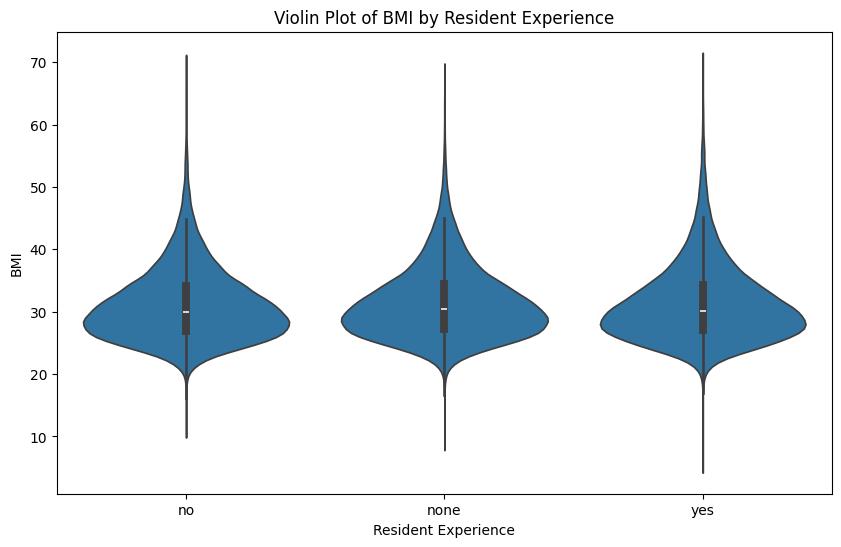

In [18]:
# prompt: crosstab resident experience by BMI and make violin plots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame (as defined in the provided code)
# and it contains columns 'bmi_end_pregnancy_2044' and 'resident_experience' (or a similar column)

# Create the cross-tabulation
crosstab_data = pd.crosstab(neuraxial_catheter_df['bmi_end_pregnancy_2044'], neuraxial_catheter_df['highly_experienced_resident'])

# Display the cross-tabulation
print("Crosstab of Resident Experience by BMI:")
print(crosstab_data)

# Create violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x='highly_experienced_resident', y='bmi_end_pregnancy_2044', data=df)
plt.xlabel('Resident Experience')  # Customize the x-axis label
plt.ylabel('BMI') # Customize the y-axis label
plt.title('Violin Plot of BMI by Resident Experience')
plt.show()

## Delivery Site

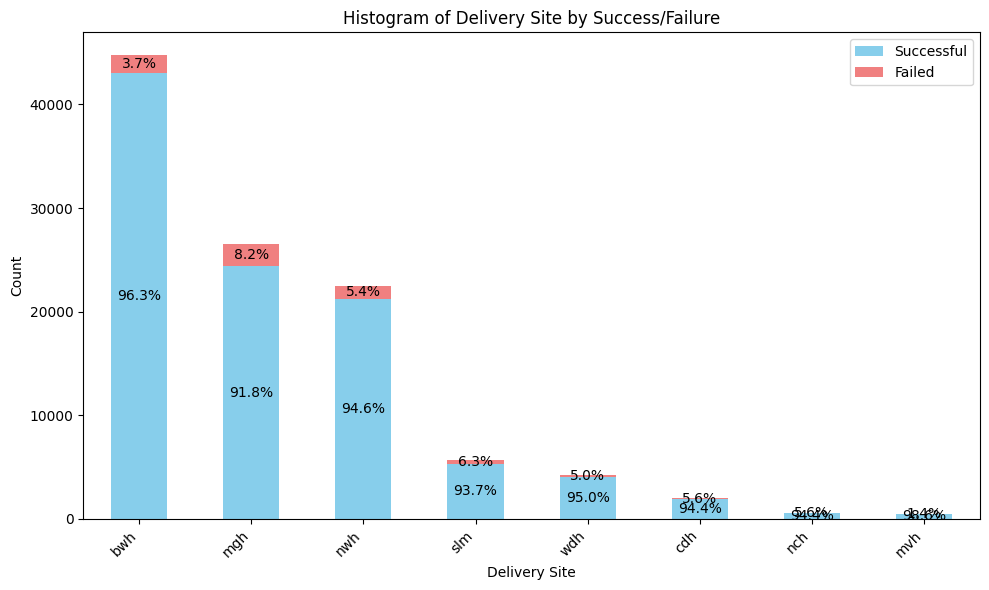

Table of Delivery Site by Success/Failure:


failed_catheter,0,1
delivery_site_2188,,
bwh,43067,1663
mgh,24364,2185
nwh,21263,1213
slm,5323,357
wdh,4058,214
cdh,1870,110
nch,543,32
mvh,480,7


In [19]:
# prompt: create a similar histogram of delivery_site_2188 using crosstab

# Create a crosstab for 'delivery_site_2188' and visualize it as a histogram
delivery_site_counts = pd.crosstab(neuraxial_catheter_df['delivery_site_2188'], neuraxial_catheter_df['failed_catheter'])

# Sort the bars in descending order based on the total count of each delivery site
delivery_site_counts = delivery_site_counts.sort_values(by=0, ascending=False)

# Create a stacked bar chart
ax = delivery_site_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Delivery Site')
plt.ylabel('Count')
plt.title('Histogram of Delivery Site by Success/Failure')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Delivery Site by Success/Failure:")
delivery_site_counts

## DPE

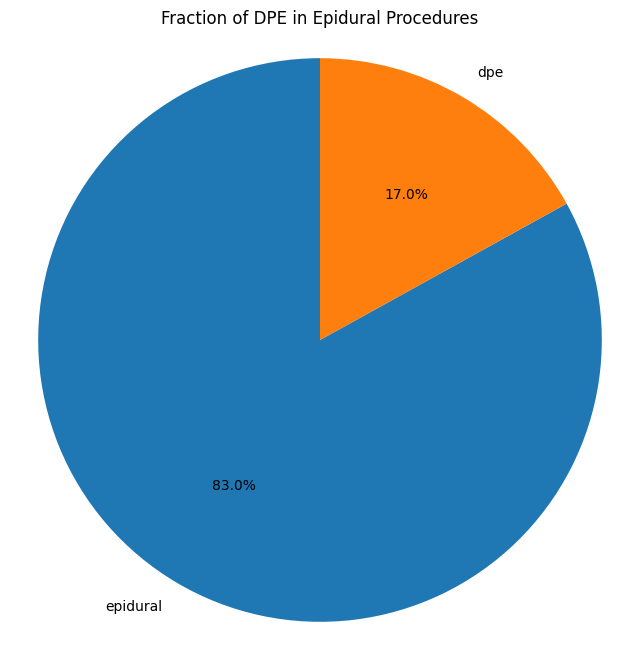

In [20]:
# prompt: create a pie chart of the fraction of DPE in epidural_df

# Count DPE values, treating NaN and '' as "no"
dpe_counts = epidural_df['true_procedure_type_incl_dpe'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(dpe_counts, labels=dpe_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Fraction of DPE in Epidural Procedures')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

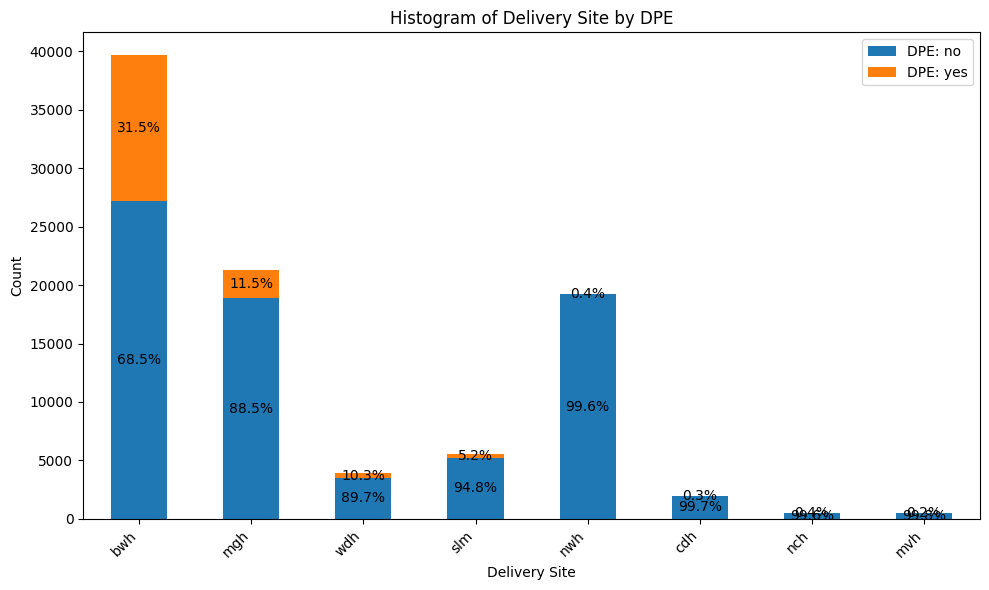

Table of Delivery Site by DPE:


true_procedure_type_incl_dpe,0,1
delivery_site_2188,,
bwh,27181,12475
mgh,18872,2463
wdh,3495,400
slm,5233,287
nwh,19200,78
cdh,1970,6
nch,492,2
mvh,485,1


In [21]:
# prompt: reproduce the above histogram using crosstab on delivery_site_2188 and dpe

# Assuming 'df' is your DataFrame (as defined in the provided code)

# Create a crosstab for 'delivery_site_2188' and 'dpe' and visualize it as a histogram
delivery_site_dpe_counts = pd.crosstab(epidural_df['delivery_site_2188'], (epidural_df['true_procedure_type_incl_dpe'] == 'dpe').astype(int))

# Sort the bars in descending order based on the total count of each delivery site
delivery_site_dpe_counts = delivery_site_dpe_counts.sort_values(by=1, ascending=False) # Sort by 'no'

# Create a stacked bar chart
ax = delivery_site_dpe_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Delivery Site')
plt.ylabel('Count')
plt.title('Histogram of Delivery Site by DPE')
plt.xticks(rotation=45, ha='right')
plt.legend(['DPE: no', 'DPE: yes']) # Update legend labels
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Delivery Site by DPE:")
delivery_site_dpe_counts

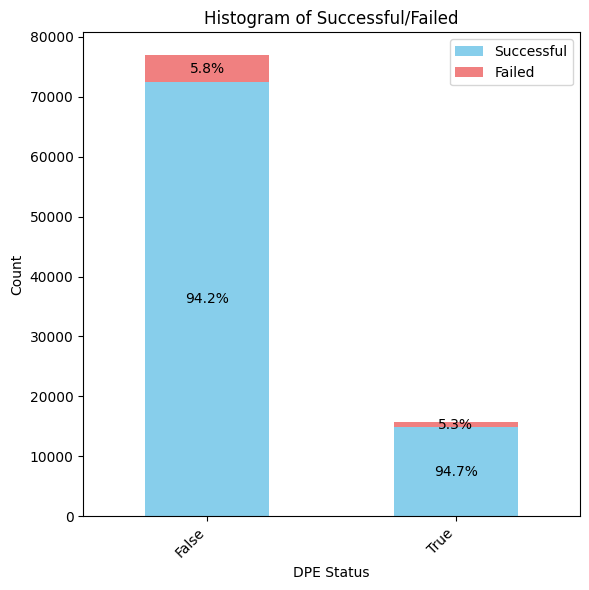

In [22]:
# Histogram of successes/failures by DPE status

# Group by procedure type and whether it has subsequent anesthesia
dpe_crosstab = pd.crosstab(epidural_df['true_procedure_type_incl_dpe'] == 'dpe', epidural_df['failed_catheter'])

# Create a stacked bar chart
ax = dpe_crosstab.plot(kind='bar', stacked=True, figsize=(6
, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
  width = p.get_width()
  height = p.get_height()
  x, y = p.get_xy()
  ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('DPE Status')
plt.ylabel('Count')
plt.title('Histogram of Successful/Failed')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()


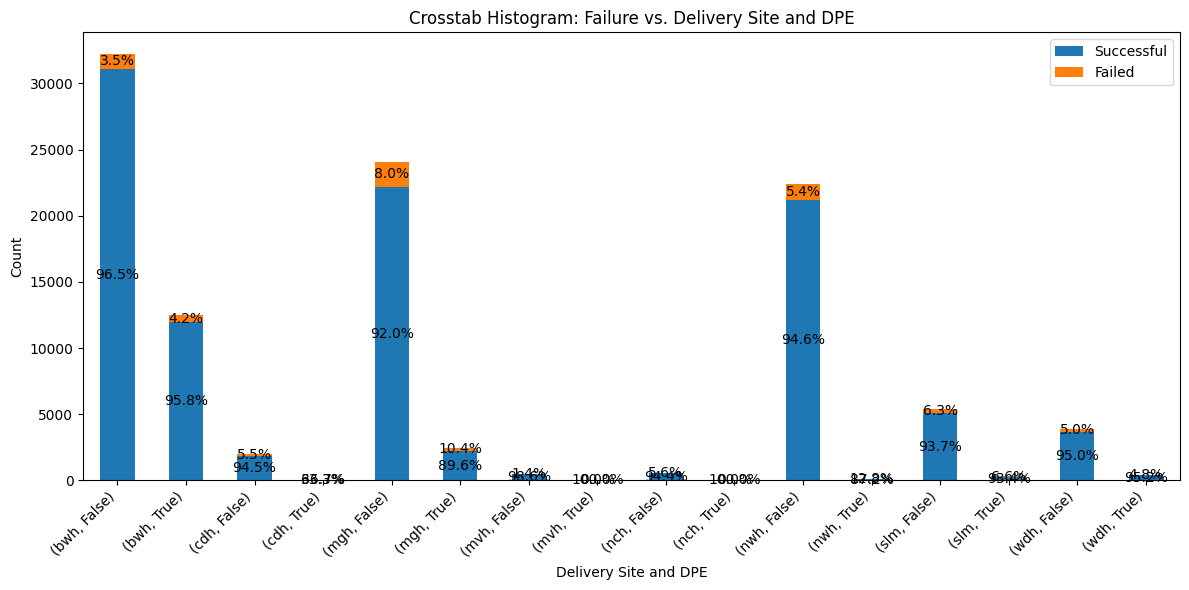

Crosstab Table:


failed_catheter                                      0     1
delivery_site_2188 true_procedure_type_incl_dpe             
bwh                False                         31112  1143
                   True                          11955   520
cdh                False                          1866   108
                   True                              4     2
mgh                False                         22158  1928
                   True                           2206   257
mvh                False                           479     7
                   True                              1     0
nch                False                           541    32
                   True                              2     0
nwh                False                         21195  1203
                   True                             68    10
slm                False                          5055   338
                   True                            268    19
wdh                False                          3677   195
                   True                            381    19

In [23]:
# prompt: do a crosstab histogram of failure versus delivery_site_2188 and dpe

# Assuming 'df' is your DataFrame (as defined in the provided code)

# Create a crosstab for 'delivery_site_2188', 'dpe', and 'failed_catheter'
crosstab_df = pd.crosstab([neuraxial_catheter_df['delivery_site_2188'], neuraxial_catheter_df['true_procedure_type_incl_dpe'] == 'dpe'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = crosstab_df.plot(kind='bar', stacked=True, figsize=(12, 6))

# Annotate the bars with percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')


plt.xlabel('Delivery Site and DPE')
plt.ylabel('Count')
plt.title('Crosstab Histogram: Failure vs. Delivery Site and DPE')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the crosstab table
print("Crosstab Table:")
crosstab_df

## Scoliosis and back problems

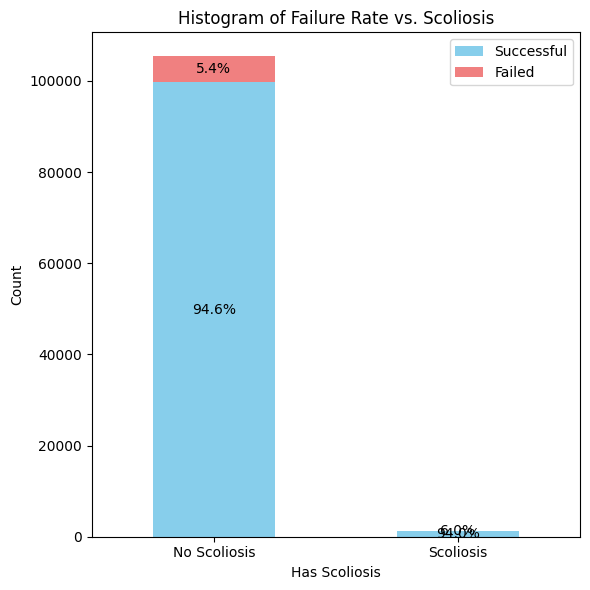

Table of Failure Rate vs. Scoliosis:


failed_catheter,0,1
has_scoliosis,,
0,99693,5699
1,1276,82


In [24]:
# prompt: create a histogram of the crosstab of has_scoliosis vs failure_rate

# Assuming 'neuraxial_catheter_df' is your DataFrame (as defined in the provided code)

# Group by 'has_scoliosis' and 'failed_catheter'
scoliosis_failure_counts = pd.crosstab(neuraxial_catheter_df['has_scoliosis'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = scoliosis_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Has Scoliosis')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Scoliosis')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Scoliosis', 'Scoliosis'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Scoliosis:")
scoliosis_failure_counts

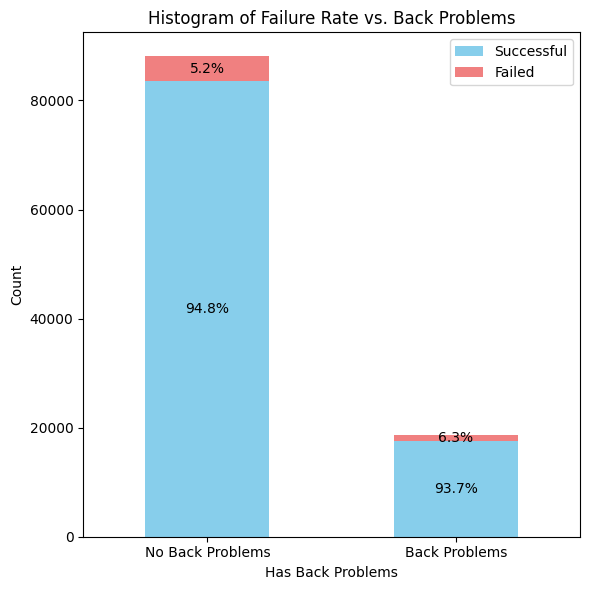

Table of Failure Rate vs. Back Problems:


failed_catheter,0,1
has_back_problems,,
0,83494,4599
1,17475,1182


In [25]:
# prompt: do the same but for has_back_problems

# Group by 'has_back_problems' and 'failed_catheter'
back_problems_failure_counts = pd.crosstab(neuraxial_catheter_df['has_back_problems'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = back_problems_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Has Back Problems')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Back Problems')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Back Problems', 'Back Problems'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Back Problems:")
back_problems_failure_counts

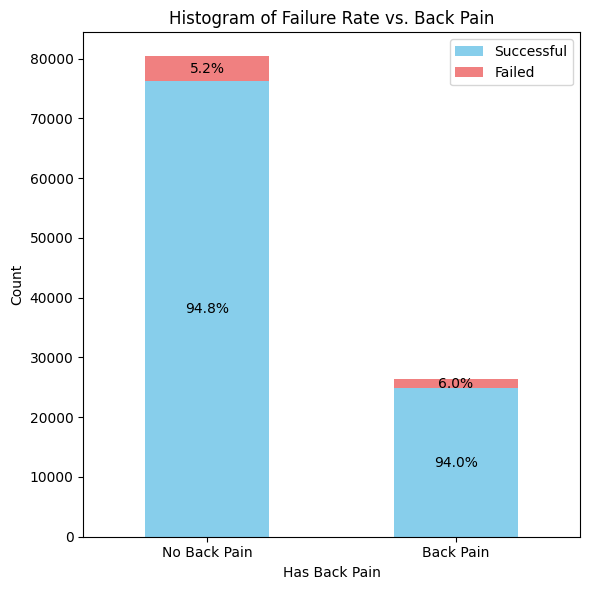

Table of Failure Rate vs. Back Pain:


failed_catheter,0,1
has_dorsalgia,,
0,76169,4196
1,24800,1585


In [26]:
# prompt: do the same but for has_dorsalgia

# Group by 'has_dorsalgia' and 'failed_catheter'
back_pain_failure_counts = pd.crosstab(neuraxial_catheter_df['has_dorsalgia'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = back_pain_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Has Back Pain')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Back Pain')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Back Pain', 'Back Pain'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Back Pain:")
back_pain_failure_counts

## Fetal Presentation

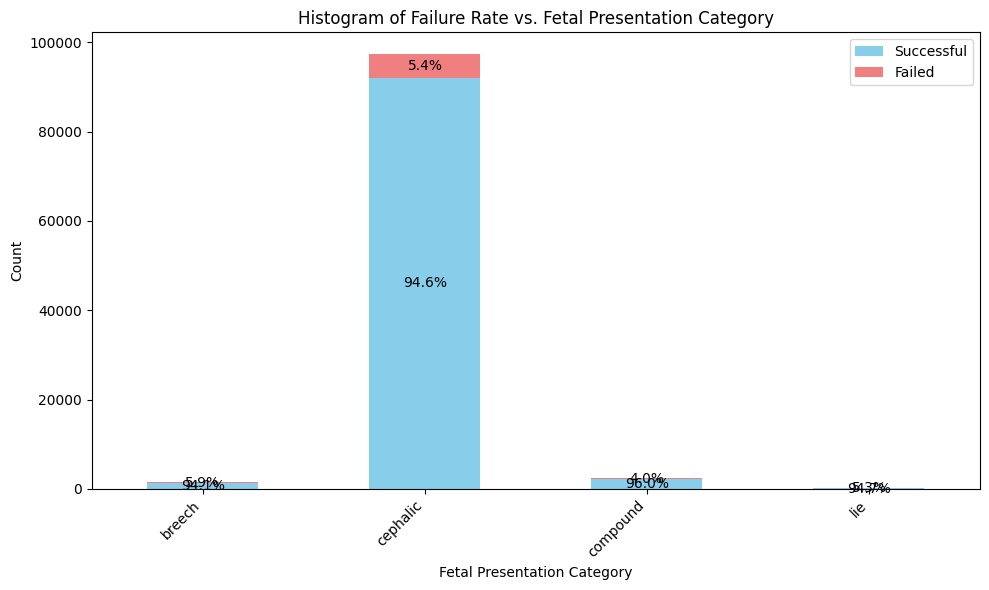

Table of Failure Rate vs. Fetal Presentation Category:


failed_catheter,0,1
fetal_presentation_category_2243,,
breech,1394,87
cephalic,92070,5280
compound,2281,94
lie,195,11


In [27]:
# prompt: do the same histogram, but for fetal_presentation_category vs failure

# Group by 'fetal_presentation_category_2243' and 'failed_catheter'
fetal_presentation_failure_counts = pd.crosstab(neuraxial_catheter_df['fetal_presentation_category_2243'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = fetal_presentation_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Fetal Presentation Category')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Fetal Presentation Category')
plt.xticks(rotation=45, ha='right')
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Fetal Presentation Category:")
fetal_presentation_failure_counts

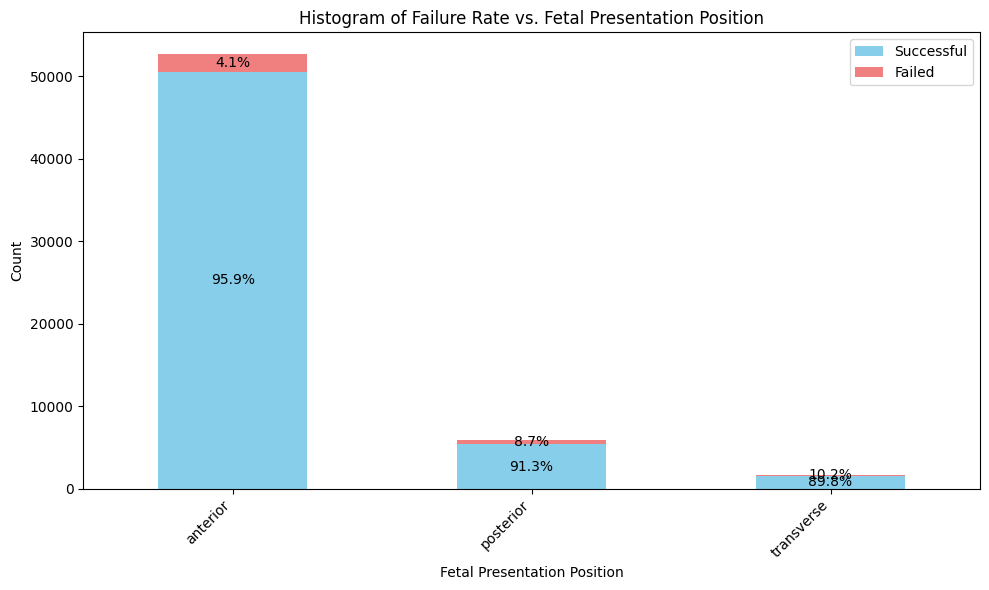

Table of Failure Rate vs. Fetal Presentation Position:


failed_catheter,0,1
fetal_presentation_position_2247,,
anterior,50522,2154
posterior,5354,510
transverse,1503,170


In [28]:
# prompt: do the same histogram, but for fetal_presentation_position vs failure

# Assuming 'neuraxial_catheter_df' is your DataFrame (as defined in the provided code)

# Group by 'fetal_presentation_position_2247' and 'failed_catheter'
fetal_position_failure_counts = pd.crosstab(neuraxial_catheter_df['fetal_presentation_position_2247'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = fetal_position_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Fetal Presentation Position')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Fetal Presentation Position')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Fetal Presentation Position:")
fetal_position_failure_counts

## Race and SES

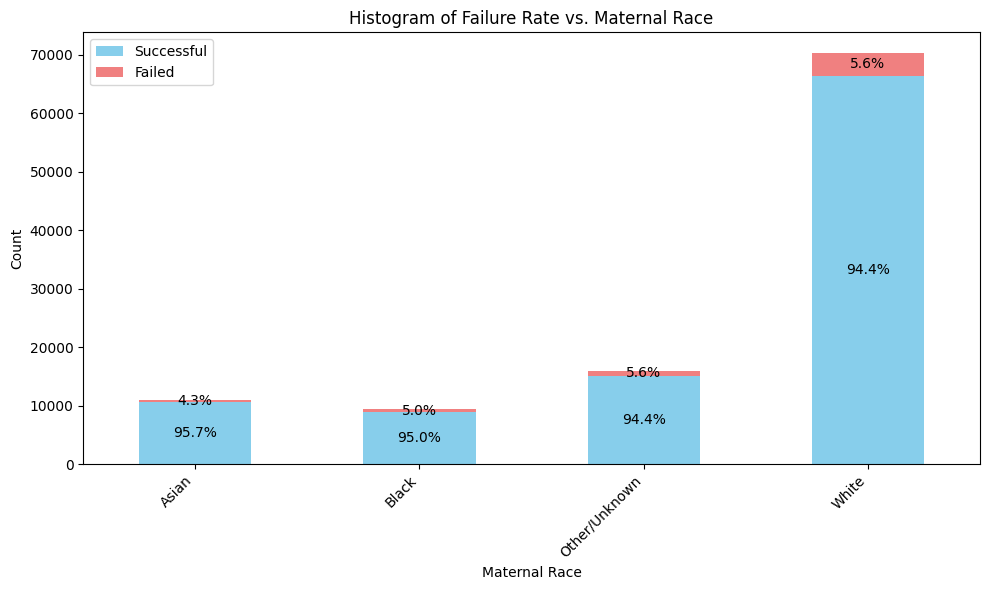

Table of Failure Rate vs. Maternal Race:


failed_catheter,0,1
maternal_race,,
Asian,10572,476
Black,8895,464
Other/Unknown,15114,892
White,66388,3949


In [29]:
# prompt: do the same histogram, but for maternal_race vs failure

# Group by 'maternal_race' and 'failed_catheter'
race_failure_counts = pd.crosstab(neuraxial_catheter_df['maternal_race'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = race_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Maternal Race')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Maternal Race')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Maternal Race:")
race_failure_counts

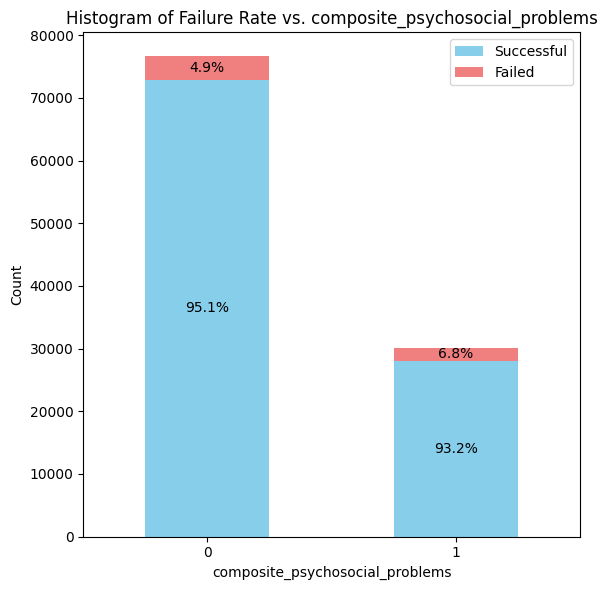

Table of Failure Rate vs. composite_psychosocial_problems:


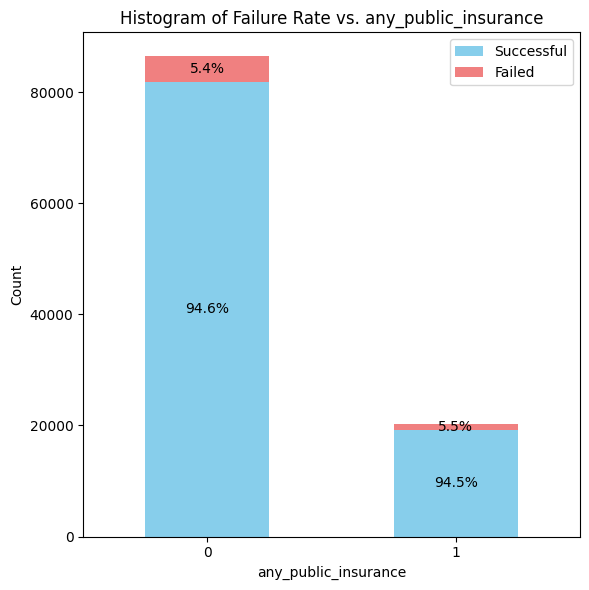

Table of Failure Rate vs. any_public_insurance:


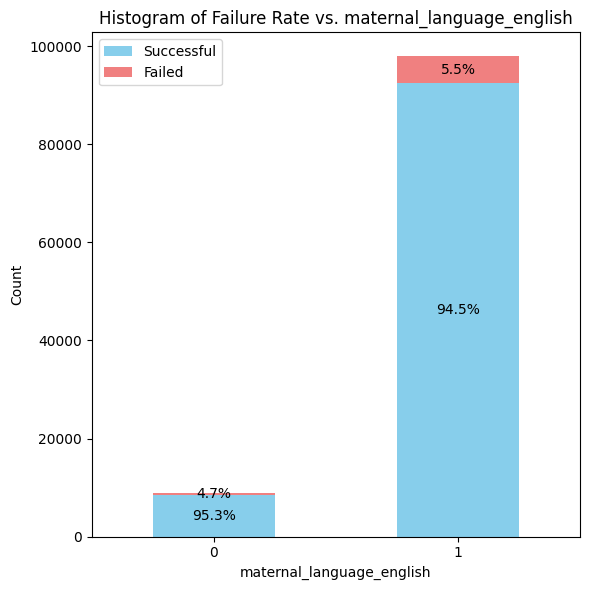

Table of Failure Rate vs. maternal_language_english:


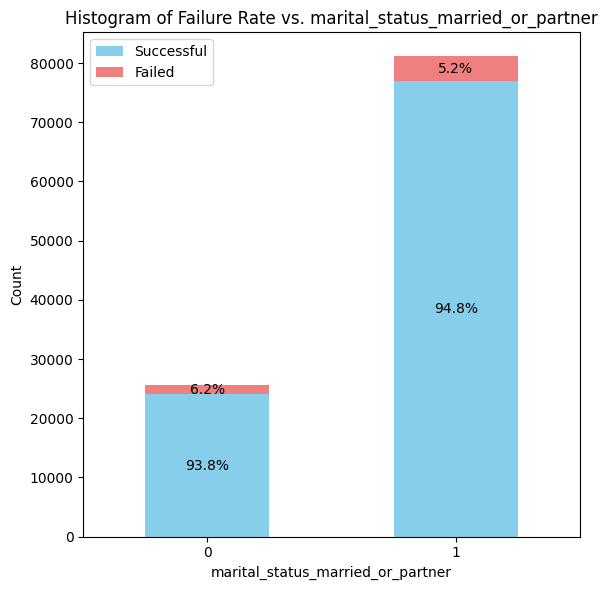

Table of Failure Rate vs. marital_status_married_or_partner:


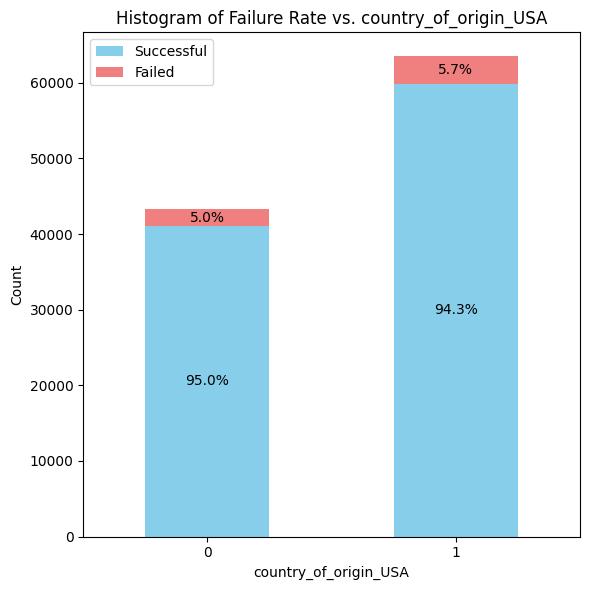

Table of Failure Rate vs. country_of_origin_USA:


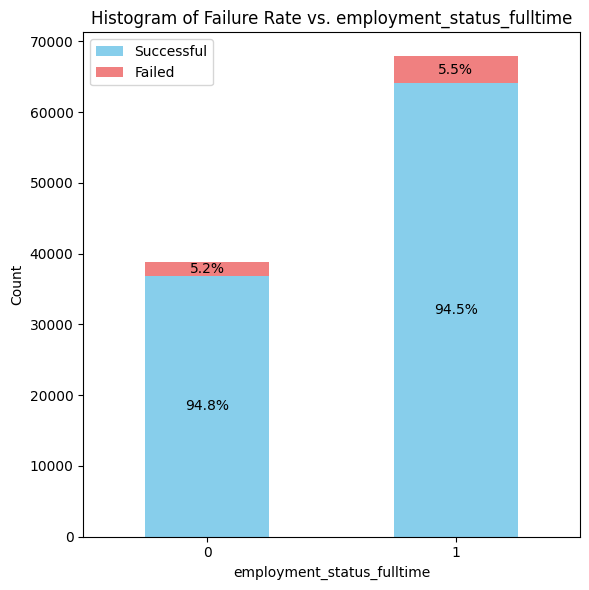

Table of Failure Rate vs. employment_status_fulltime:


failed_catheter,0,1
employment_status_fulltime,,
0,36817,2035
1,64152,3746


In [30]:
# prompt: do the same histogram, but for each of these: 32. composite_psychosocial_problems ||| int64
# 33. any_public_insurance ||| int64
# 34. maternal_language_english ||| int64
# 35. marital_status_married_or_partner ||| int64
# 36. country_of_origin_USA ||| int64
# 37. employment_status_fulltime ||| int64

# Assuming 'neuraxial_catheter_df' is your DataFrame

columns_to_analyze = [
    'composite_psychosocial_problems',
    'any_public_insurance',
    'maternal_language_english',
    'marital_status_married_or_partner',
    'country_of_origin_USA',
    'employment_status_fulltime'
]

for column in columns_to_analyze:
  # Group by the current column and 'failed_catheter'
  failure_counts = pd.crosstab(neuraxial_catheter_df[column], neuraxial_catheter_df['failed_catheter'])

  # Create a stacked bar chart
  ax = failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

  # Add percentages within each bar
  for p in ax.patches:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

  plt.xlabel(column)
  plt.ylabel('Count')
  plt.title(f'Histogram of Failure Rate vs. {column}')

  # Customize x-axis ticks and labels (adjust as needed for each column)
  plt.xticks(rotation=0, ha='center')

  plt.legend(['Successful', 'Failed'])
  plt.tight_layout()
  plt.show()

  # Display the table with the same information
  print(f"Table of Failure Rate vs. {column}:")
failure_counts

## Pain

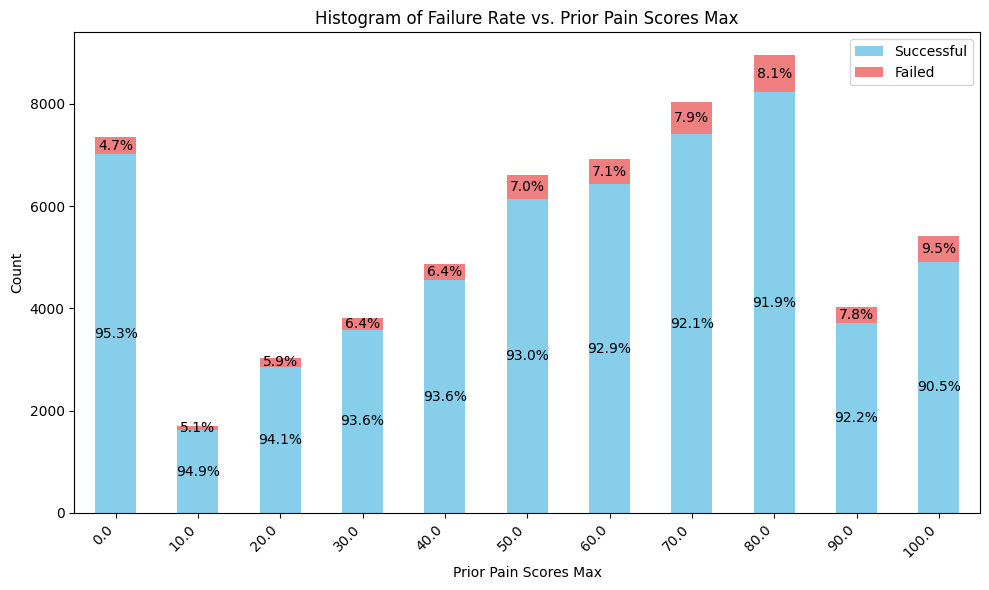

Table of Failure Rate vs. Prior Pain Scores Max:


failed_catheter,0,1
prior_pain_scores_max,,
0.0,7011,348
10.0,1615,86
20.0,2860,178
30.0,3576,243
40.0,4551,310
50.0,6144,460
60.0,6431,492
70.0,7406,636
80.0,8229,724


In [31]:
# prompt: do the same histogram but for prior_pain_scores_max

# Assuming 'neuraxial_catheter_df' is your DataFrame

# Group by 'prior_pain_scores_max' and 'failed_catheter'
prior_pain_failure_counts = pd.crosstab(neuraxial_catheter_df['prior_pain_scores_max'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = prior_pain_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Prior Pain Scores Max')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Prior Pain Scores Max')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Prior Pain Scores Max:")
prior_pain_failure_counts

## Gravidity and Parity

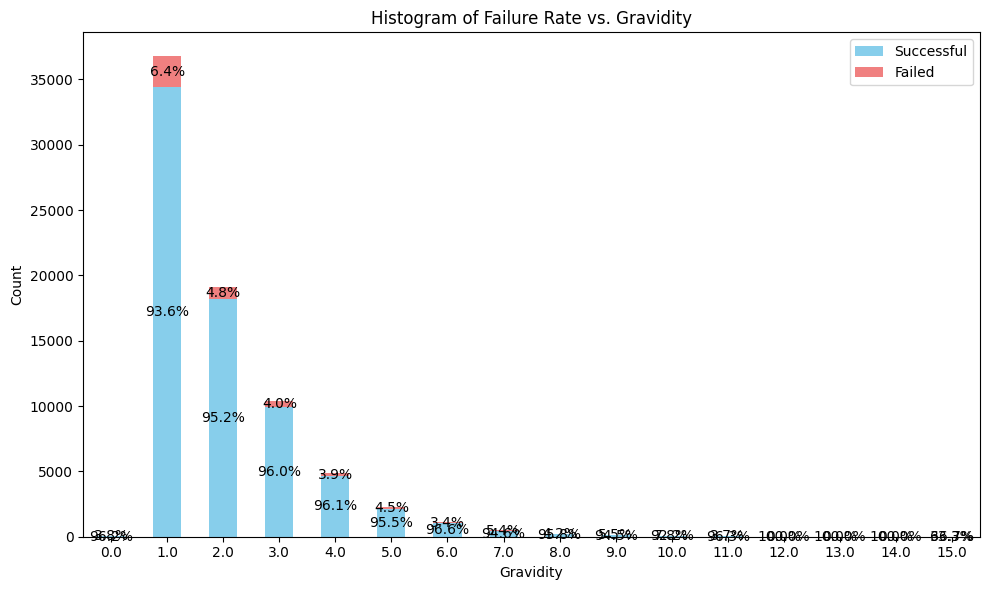

Table of Failure Rate vs. Gravidity:
failed_catheter      0     1
gravidity_2047              
0.0                 25     1
1.0              34412  2353
2.0              18161   924
3.0               9959   418
4.0               4658   190
5.0               2146   101
6.0               1059    37
7.0                456    26
8.0                230    10
9.0                121     7
10.0                59     5
11.0                26     1
12.0                14     0
13.0                 9     0
14.0                 6     0
15.0                 2     1


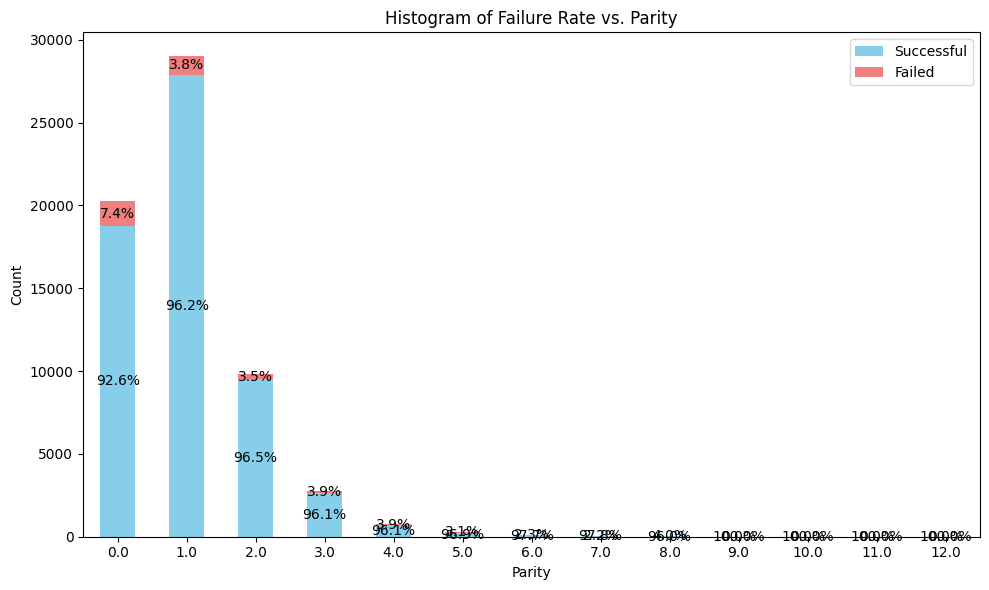

Table of Failure Rate vs. Parity:


failed_catheter,0,1
parity_2048,,
0.0,18759,1495
1.0,27905,1100
2.0,9496,343
3.0,2646,108
4.0,723,29
5.0,254,8
6.0,86,2
7.0,45,1
8.0,24,1


In [32]:
# prompt: do the same histogram but for gravidity_2047 and parity_2048

# Assuming 'neuraxial_catheter_df' is your DataFrame

# Group by 'gravidity_2047' and 'failed_catheter'
gravidity_failure_counts = pd.crosstab(neuraxial_catheter_df['gravidity_2047'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = gravidity_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Gravidity')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Gravidity')
plt.xticks(rotation=0)  # Adjust rotation if needed
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table
print("Table of Failure Rate vs. Gravidity:")
print(gravidity_failure_counts)


# Group by 'parity_2048' and 'failed_catheter'
parity_failure_counts = pd.crosstab(neuraxial_catheter_df['parity_2048'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = parity_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Parity')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Parity')
plt.xticks(rotation=0)  # Adjust rotation if needed
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table
print("Table of Failure Rate vs. Parity:")
parity_failure_counts

## BMI / height / weight

C:\Users\User\AppData\Local\Temp\ipykernel_19544\1136609773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['bmi_end_pregnancy_bin'] = (df_plot['bmi_end_pregnancy_2044'] // 1).astype(int)


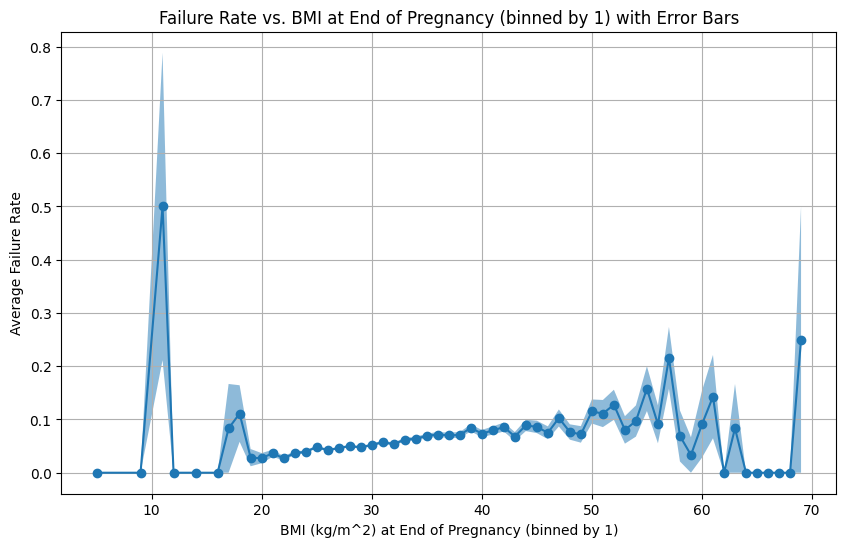

In [33]:
# prompt: plot bmi end pregnancy against failure rate using binning as above.

# Assuming 'bmi_end_pregnancy' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['bmi_end_pregnancy_2044', 'failed_catheter'])

# Bin the bmi_end_pregnancy
df_plot['bmi_end_pregnancy_bin'] = (df_plot['bmi_end_pregnancy_2044'] // 1).astype(int)

# Group by the binned bmi_end_pregnancy and calculate the mean and standard error of the mean of failed_catheter
failure_by_bmi = df_plot.groupby('bmi_end_pregnancy_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_bmi.index, failure_by_bmi['mean'], marker='o')
plt.fill_between(failure_by_bmi.index,
                 failure_by_bmi['mean'] - failure_by_bmi['sem'],
                 failure_by_bmi['mean'] + failure_by_bmi['sem'],
                 alpha=0.5) # Add shaded error bars

plt.xlabel('BMI (kg/m^2) at End of Pregnancy (binned by 1)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. BMI at End of Pregnancy (binned by 1) with Error Bars')
plt.grid(True)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_19544\1989362899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['weight_end_pregnancy_bin'] = (df_plot['maternal_weight_end_pregnancy_2045'] // 10).astype(int) * 10


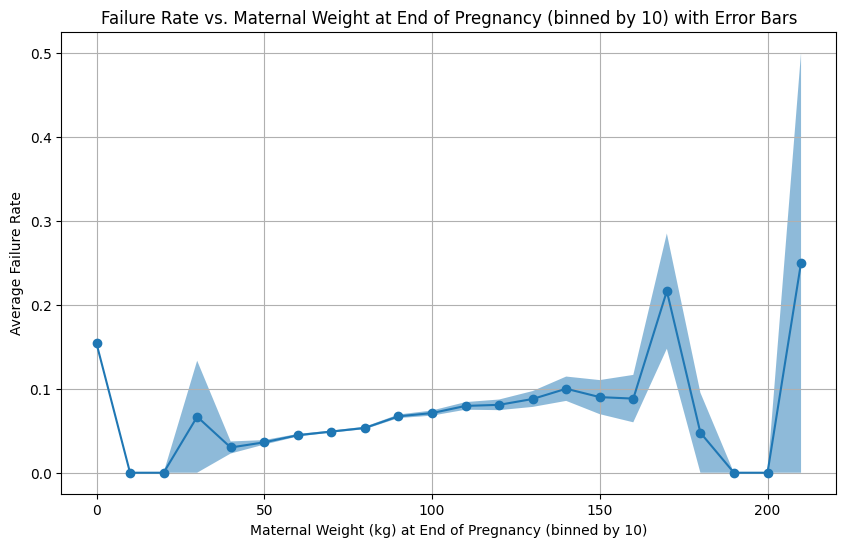

In [34]:
# prompt: # prompt: plot weight end pregnancy against failure rate using binning as above.

# Assuming 'maternal_weight_end_pregnancy_2045' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['maternal_weight_end_pregnancy_2045', 'failed_catheter'])

# Bin the maternal weight at the end of pregnancy
df_plot['weight_end_pregnancy_bin'] = (df_plot['maternal_weight_end_pregnancy_2045'] // 10).astype(int) * 10

# Group by the binned weight and calculate the mean and standard error of the mean of failed_catheter
failure_by_weight = df_plot.groupby('weight_end_pregnancy_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_weight.index, failure_by_weight['mean'], marker='o')
plt.fill_between(failure_by_weight.index,
                 failure_by_weight['mean'] - failure_by_weight['sem'],
                 failure_by_weight['mean'] + failure_by_weight['sem'],
                 alpha=0.5)  # Add shaded error bars

plt.xlabel('Maternal Weight (kg) at End of Pregnancy (binned by 10)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Maternal Weight at End of Pregnancy (binned by 10) with Error Bars')
plt.grid(True)
plt.show()

In [35]:
# # prompt: do the same but for height

# # Assuming 'height' is a column in your DataFrame 'df'
# df_plot = neuraxial_catheter_df.dropna(subset=['maternal_height_2046', 'failed_catheter'])

# # Drop heights greater than 250
# df_plot = df_plot[df_plot['maternal_height_2046'] <= 250]

# # Bin the height
# df_plot['height_bin'] = (df_plot['maternal_height_2046'] // 1).astype(int)

# # Group by the binned height and calculate the mean and standard error of the mean of failed_catheter
# failure_by_height = df_plot.groupby('height_bin')['failed_catheter'].agg(['mean', 'sem'])

# # Create the plot
# plt.figure(figsize=(10, 6))
# plt.plot(failure_by_height.index, failure_by_height['mean'], marker='o')
# plt.fill_between(failure_by_height.index,
#                  failure_by_height['mean'] - failure_by_height['sem'],
#                  failure_by_height['mean'] + failure_by_height['sem'],
#                  alpha=0.5) # Add shaded error bars

# plt.xlabel('Height (binned by 1)')
# plt.ylabel('Average Failure Rate')
# plt.title('Failure Rate vs. Height (binned by 1) with Error Bars')
# plt.grid(True)
# plt.show()

## Needle Type

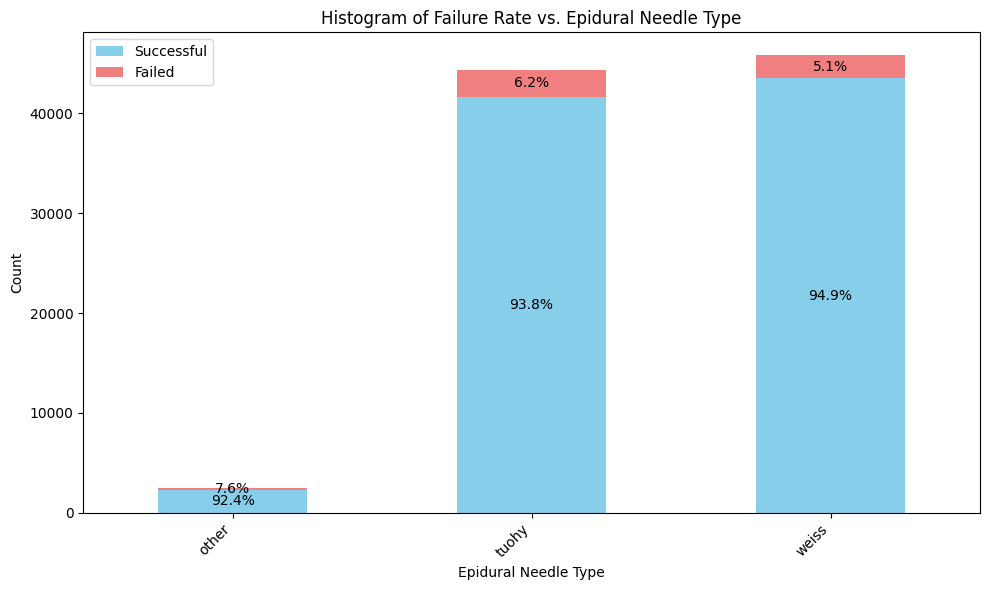

Table of Failure Rate vs. Epidural Needle Type:


failed_catheter,0,1
epidural_needle_type,,
other,2264,186
tuohy,41611,2759
weiss,43492,2328


In [36]:
# prompt: do the same histogram but for epidural_needle_type

# Assuming 'epidural_df' is your DataFrame (as defined in the provided code)

# Group by 'epidural_needle_type' and 'failed_catheter'
needle_type_failure_counts = pd.crosstab(epidural_df['epidural_needle_type'], epidural_df['failed_catheter'])

# Create a stacked bar chart
ax = needle_type_failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Epidural Needle Type')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Epidural Needle Type')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Epidural Needle Type:")
needle_type_failure_counts

## Paresthesias

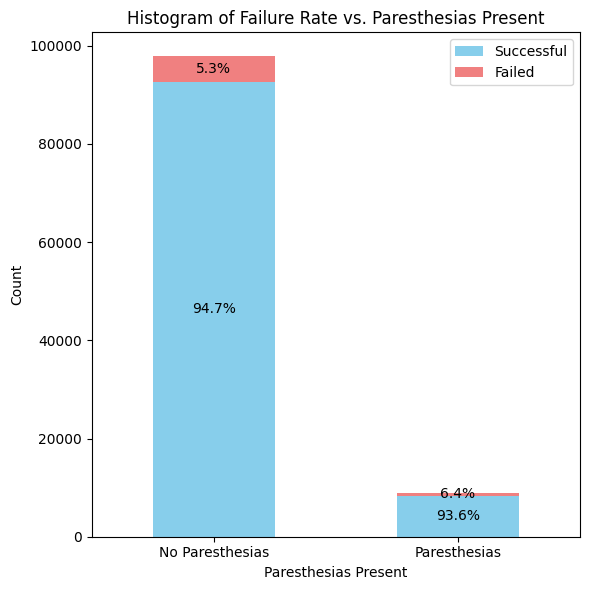

Table of Failure Rate vs. Paresthesias Present:


failed_catheter,0,1
paresthesias_present,,
0,92639,5210
1,8330,571


In [37]:
# prompt: do the same histogram but for paresthesias_present

# Group by 'paresthesias_present' and 'failed_catheter'
paresthesias_failure_counts = pd.crosstab(neuraxial_catheter_df['paresthesias_present'], neuraxial_catheter_df['failed_catheter'])

# Create a stacked bar chart
ax = paresthesias_failure_counts.plot(kind='bar', stacked=True, figsize=(6, 6), color=['skyblue', 'lightcoral'])

# Add percentages within each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height/sum([p.get_height() for p in ax.patches if p.get_x() == x]) * 100:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.xlabel('Paresthesias Present')
plt.ylabel('Count')
plt.title('Histogram of Failure Rate vs. Paresthesias Present')
plt.xticks(rotation=0, ha='center', ticks=[0, 1], labels=['No Paresthesias', 'Paresthesias'])
plt.legend(['Successful', 'Failed'])
plt.tight_layout()
plt.show()

# Display the table with the same information
print("Table of Failure Rate vs. Paresthesias Present:")
paresthesias_failure_counts

## Number of Attempts

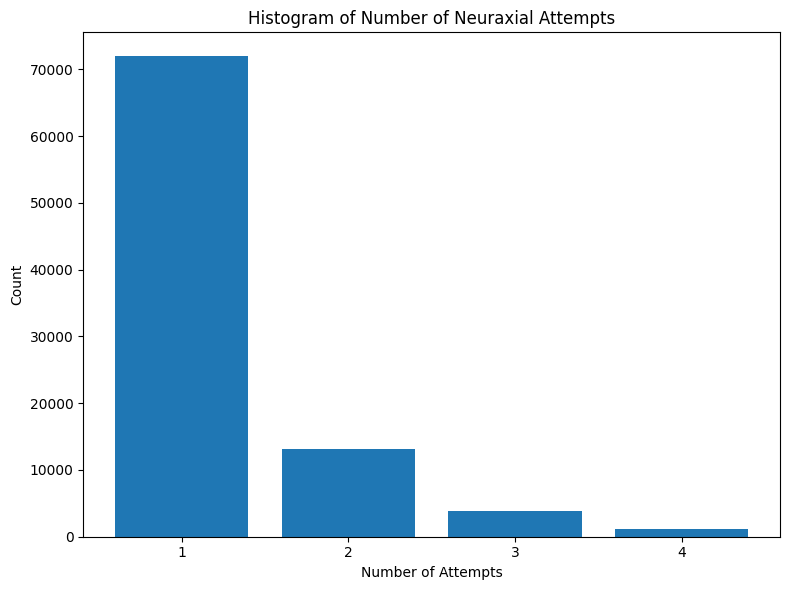

In [38]:
# prompt: create a histogram of the number of attempts. Only show integers on the x-axis

# Assuming 'number_of_neuraxial_attempts' is a column in your DataFrame 'df'
attempts_counts = df['number_of_neuraxial_attempts'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(attempts_counts.index, attempts_counts.values)
plt.xlabel('Number of Attempts')
plt.ylabel('Count')
plt.title('Histogram of Number of Neuraxial Attempts')
plt.xticks(range(int(attempts_counts.index.min()), int(attempts_counts.index.max()) + 1))  # Show only integer ticks on x-axis
plt.tight_layout()
plt.show()


## Loss of Resistance Depth

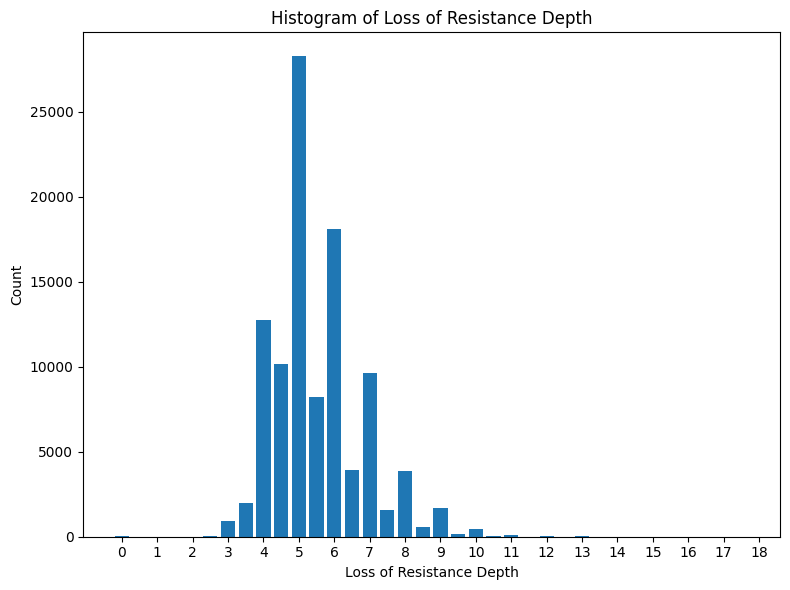

In [39]:
# prompt: create a histogram of loss of resistance depth. Center the bars over the tick marks and make space between the bars. Bins should be every 0.5

# Assuming 'lor_depth' is a column in your DataFrame 'df'
lor_depths = neuraxial_catheter_df['lor_depth'].dropna()  # Remove NaN values

# Create the histogram with centered bars and spacing
plt.figure(figsize=(8, 6))
plt.hist(lor_depths, bins=np.arange(lor_depths.min(), lor_depths.max() + 0.5, 0.5), rwidth=0.8, align='left')
plt.xlabel('Loss of Resistance Depth')
plt.ylabel('Count')
plt.title('Histogram of Loss of Resistance Depth')
plt.xticks(np.arange(0, lor_depths.max() + 0.5, 1))  # Set x-axis ticks to be at every 1
plt.tight_layout()
plt.show()


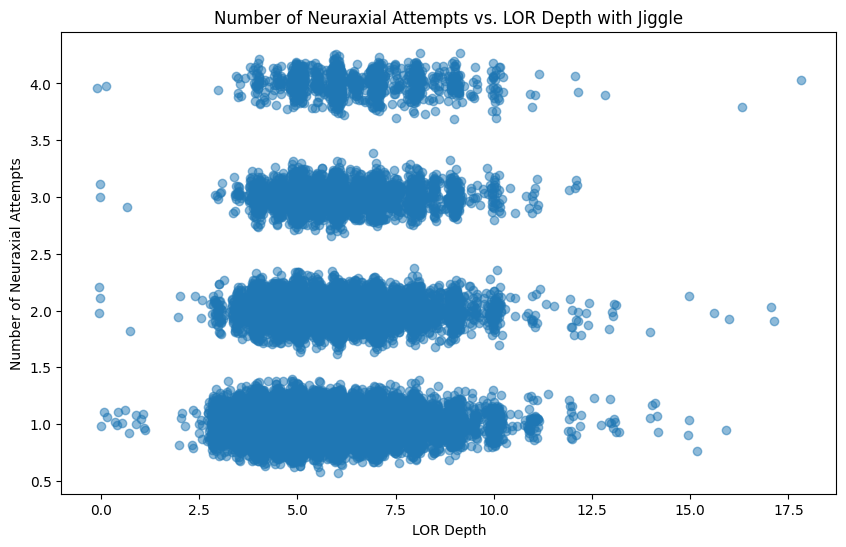

In [40]:
# prompt: Plot number of neuraxial attempts vs LOR depth on the x-axis. Add jiggle to both x and y axes

df_plot = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts', 'lor_depth'])

# Add random jiggle to both x and y axes
jiggle_x = np.random.normal(scale = 0.1, size=len(df_plot))
jiggle_y = np.random.normal(scale = 0.1, size=len(df_plot))

plt.figure(figsize=(10, 6))
plt.scatter(df_plot['lor_depth'] + jiggle_x, df_plot['number_of_neuraxial_attempts'] + jiggle_y, alpha=0.5)
plt.xlabel('LOR Depth')
plt.ylabel('Number of Neuraxial Attempts')
plt.title('Number of Neuraxial Attempts vs. LOR Depth with Jiggle')
plt.show()


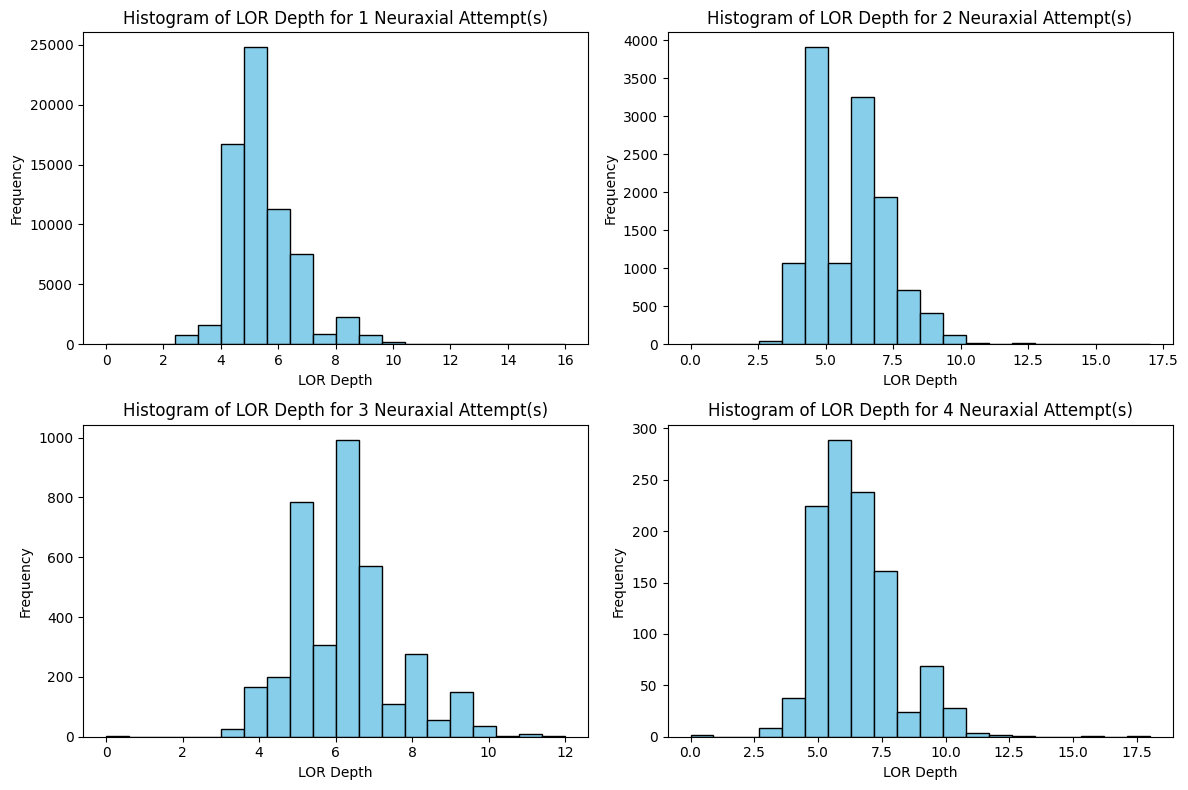

In [41]:
import matplotlib.pyplot as plt

# Extract the data, dropping NaNs
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'number_of_neuraxial_attempts'])

# Create a list of unique values in 'number_of_neuraxial_attempts'
attempts = [1, 2, 3, 4]

# Create histograms for each number_of_neuraxial_attempts
plt.figure(figsize=(12, 8))

for i, attempt in enumerate(attempts, start=1):
    # Filter data for each attempt
    subset = df_plot[df_plot['number_of_neuraxial_attempts'] == attempt]
    
    # Plot histogram for 'lor_depth'
    plt.subplot(2, 2, i)
    plt.hist(subset['lor_depth'], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of LOR Depth for {attempt} Neuraxial Attempt(s)')
    plt.xlabel('LOR Depth')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


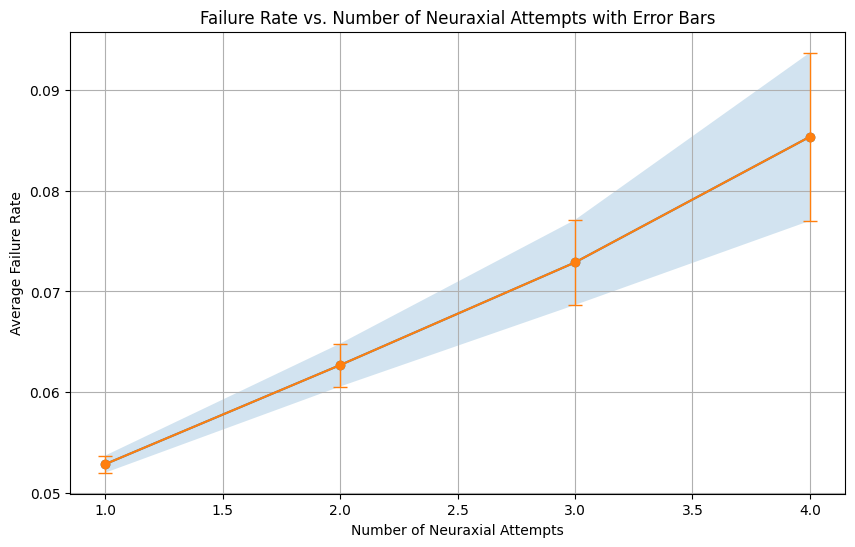

In [42]:
# prompt: do the same but add shaded error bars for +/- standard error of the mean

# Assuming 'number_of_neuraxial_attempts' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts'])

# Group by number of attempts and calculate the mean and standard error of the mean of failed_catheter
failure_by_attempts = df_plot.groupby('number_of_neuraxial_attempts')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot with error bars
plt.figure(figsize=(10, 6))
plt.plot(failure_by_attempts.index, failure_by_attempts['mean'], marker='o')
plt.fill_between(failure_by_attempts.index,
                 failure_by_attempts['mean'] - failure_by_attempts['sem'],
                 failure_by_attempts['mean'] + failure_by_attempts['sem'],
                 alpha=0.2) # Add shaded error bars
plt.errorbar(failure_by_attempts.index, failure_by_attempts['mean'], yerr=failure_by_attempts['sem'], fmt='o-', capsize=5, elinewidth=1)  # Added error bars
plt.xlabel('Number of Neuraxial Attempts')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Number of Neuraxial Attempts with Error Bars')
plt.grid(True)
plt.show()

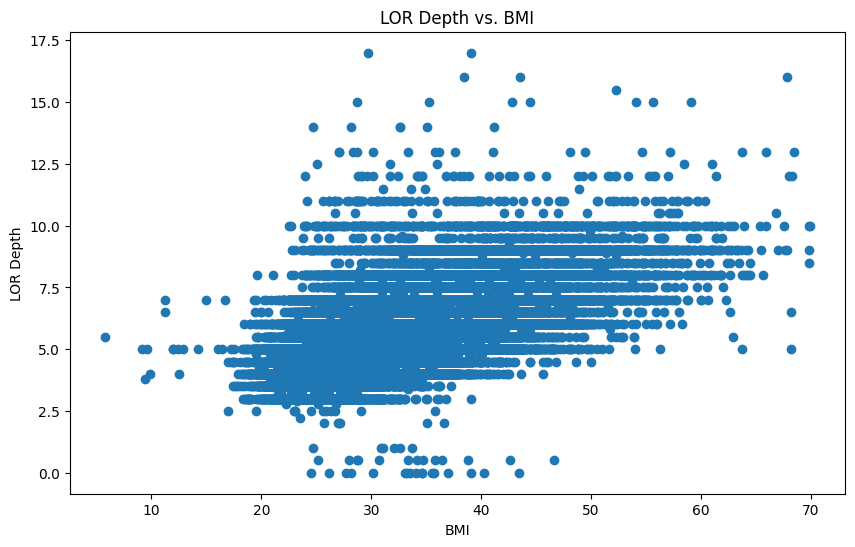

In [43]:
# prompt: Plot lor-depth against bmi

# Assuming 'lor_depth' and 'bmi_end_pregnancy_2044' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'bmi_end_pregnancy_2044'])

plt.figure(figsize=(10, 6))
plt.scatter(df_plot['bmi_end_pregnancy_2044'], df_plot['lor_depth'])
plt.xlabel('BMI')
plt.ylabel('LOR Depth')
plt.title('LOR Depth vs. BMI')
plt.show()

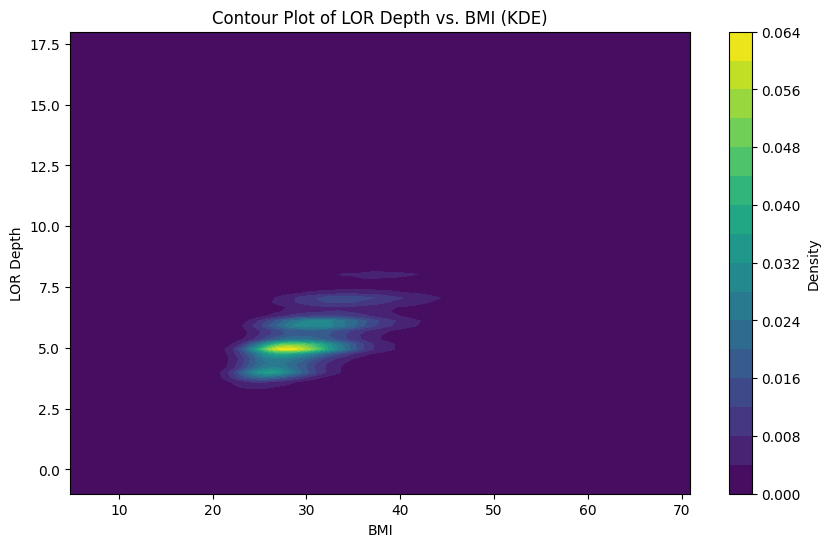

In [44]:
# from scipy.stats import gaussian_kde

# # Extract the data, dropping NaNs
# df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'bmi_end_pregnancy_2044'])
# x = df_plot['bmi_end_pregnancy_2044'].values
# y = df_plot['lor_depth'].values

# # Perform kernel density estimation
# xy = np.vstack([x, y])
# kde = gaussian_kde(xy)

# # Define grid over data range
# xmin, xmax = x.min() - 1, x.max() + 1
# ymin, ymax = y.min() - 1, y.max() + 1
# X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# positions = np.vstack([X.ravel(), Y.ravel()])
# Z = np.reshape(kde(positions).T, X.shape)

# # Create the contour plot
# plt.figure(figsize=(10, 6))
# plt.contourf(X, Y, Z, levels=15, cmap='viridis')
# plt.colorbar(label='Density')
# plt.xlabel('BMI')
# plt.ylabel('LOR Depth')
# plt.title('Contour Plot of LOR Depth vs. BMI (KDE)')
# plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_19544\3491618410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['lor_depth_bin'] = (df_plot['lor_depth'] // 1).astype(int)


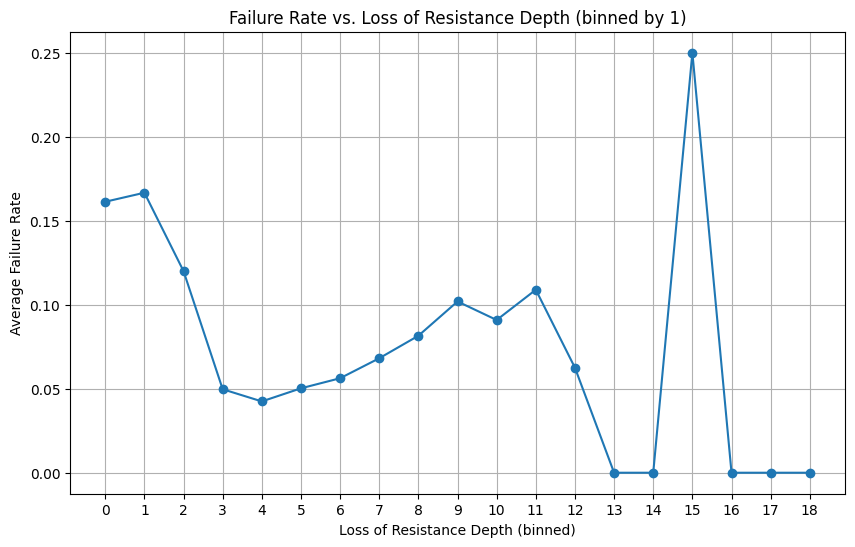

In [45]:
# prompt: do the same but for failure vs loss of resistance depth. Bin the depth by units of 1

# Assuming 'lor_depth' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'failed_catheter'])

# Bin the LOR depth
df_plot['lor_depth_bin'] = (df_plot['lor_depth'] // 1).astype(int)

# Group by the binned LOR depth and calculate the mean of failed_catheter
failure_by_lor_depth = df_plot.groupby('lor_depth_bin')['failed_catheter'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_lor_depth.index, failure_by_lor_depth.values, marker='o')
plt.xlabel('Loss of Resistance Depth (binned)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Loss of Resistance Depth (binned by 1)')
plt.xticks(np.arange(0, df_plot['lor_depth'].max() + 0.5, 1))  # Set x-axis ticks to be at every 1
plt.grid(True)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_19544\1282687347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['lor_depth_bin'] = (df_plot['lor_depth'] // 1).astype(int)


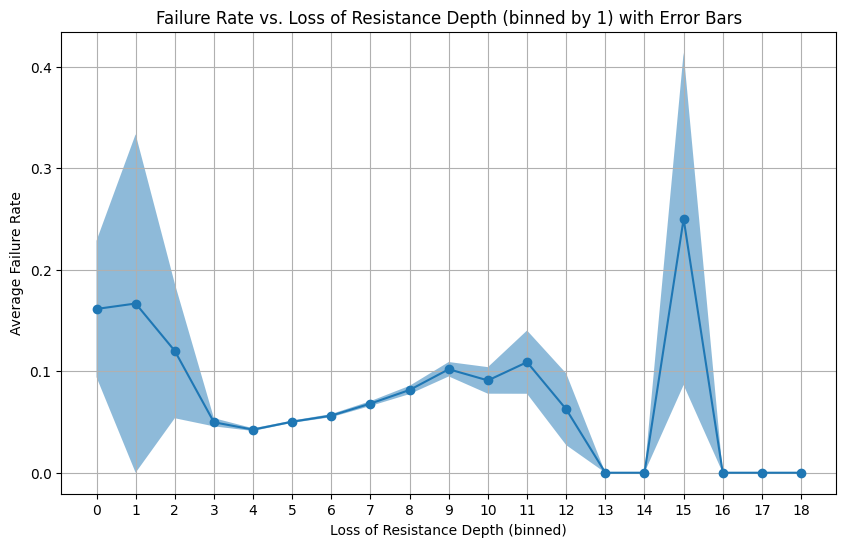

In [46]:
# prompt: Reproduce the same plot, but add shaded error bars for +/- standard error of the mean

# Assuming 'lor_depth' and 'failed_catheter' are columns in your DataFrame 'df'
df_plot = neuraxial_catheter_df.dropna(subset=['lor_depth', 'failed_catheter'])

# Bin the LOR depth
df_plot['lor_depth_bin'] = (df_plot['lor_depth'] // 1).astype(int)

# Group by the binned LOR depth and calculate the mean and standard error of the mean of failed_catheter
failure_by_lor_depth = df_plot.groupby('lor_depth_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_lor_depth.index, failure_by_lor_depth['mean'], marker='o')
plt.fill_between(failure_by_lor_depth.index,
                 failure_by_lor_depth['mean'] - failure_by_lor_depth['sem'],
                 failure_by_lor_depth['mean'] + failure_by_lor_depth['sem'],
                 alpha=0.5) # Add shaded error bars

plt.xlabel('Loss of Resistance Depth (binned)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Loss of Resistance Depth (binned by 1) with Error Bars')
plt.xticks(np.arange(0, df_plot['lor_depth'].max() + 0.5, 1))  # Set x-axis ticks to be at every 1
plt.grid(True)
plt.show()

For failed_catheter=0, slope = 0.13, intercept = 1.33
For failed_catheter=1, slope = 0.13, intercept = 1.39


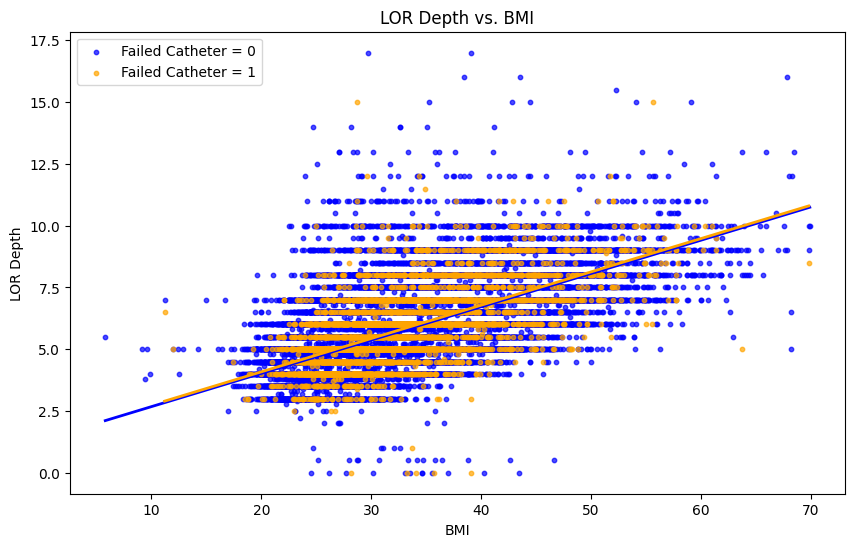

In [47]:

# Drop rows with NaNs
df_plot = neuraxial_catheter_df.dropna(
    subset=['lor_depth', 'bmi_end_pregnancy_2044', 'failed_catheter']
)

# Separate the data by failed_catheter category
df_0 = df_plot[df_plot['failed_catheter'] == 0]
df_1 = df_plot[df_plot['failed_catheter'] == 1]

plt.figure(figsize=(10, 6))

# Scatter plot for failed_catheter = 0
plt.scatter(
    df_0['bmi_end_pregnancy_2044'],
    df_0['lor_depth'],
    s=10, 
    alpha=0.7,
    color='blue',
    label='Failed Catheter = 0'
)

# Scatter plot for failed_catheter = 1
plt.scatter(
    df_1['bmi_end_pregnancy_2044'],
    df_1['lor_depth'],
    s=10, 
    alpha=0.7,
    color='orange',
    label='Failed Catheter = 1'
)

# --- Calculate and plot regression line for failed_catheter = 0 ---
p0 = np.polyfit(df_0['bmi_end_pregnancy_2044'], df_0['lor_depth'], deg=1)  # slope, intercept
slope_0, intercept_0 = p0
print(f"For failed_catheter=0, slope = {slope_0:.2f}, intercept = {intercept_0:.2f}")

x_vals_0 = np.linspace(df_0['bmi_end_pregnancy_2044'].min(), df_0['bmi_end_pregnancy_2044'].max(), 100)
y_vals_0 = np.polyval(p0, x_vals_0)
plt.plot(x_vals_0, y_vals_0, color='blue', linewidth=2)

# --- Calculate and plot regression line for failed_catheter = 1 ---
p1 = np.polyfit(df_1['bmi_end_pregnancy_2044'], df_1['lor_depth'], deg=1)
slope_1, intercept_1 = p1
print(f"For failed_catheter=1, slope = {slope_1:.2f}, intercept = {intercept_1:.2f}")

x_vals_1 = np.linspace(df_1['bmi_end_pregnancy_2044'].min(), df_1['bmi_end_pregnancy_2044'].max(), 100)
y_vals_1 = np.polyval(p1, x_vals_1)
plt.plot(x_vals_1, y_vals_1, color='orange', linewidth=2)

# Labels and legend
plt.xlabel('BMI')
plt.ylabel('LOR Depth')
plt.title('LOR Depth vs. BMI')
plt.legend()

plt.show()

## Gestational Age and Weight

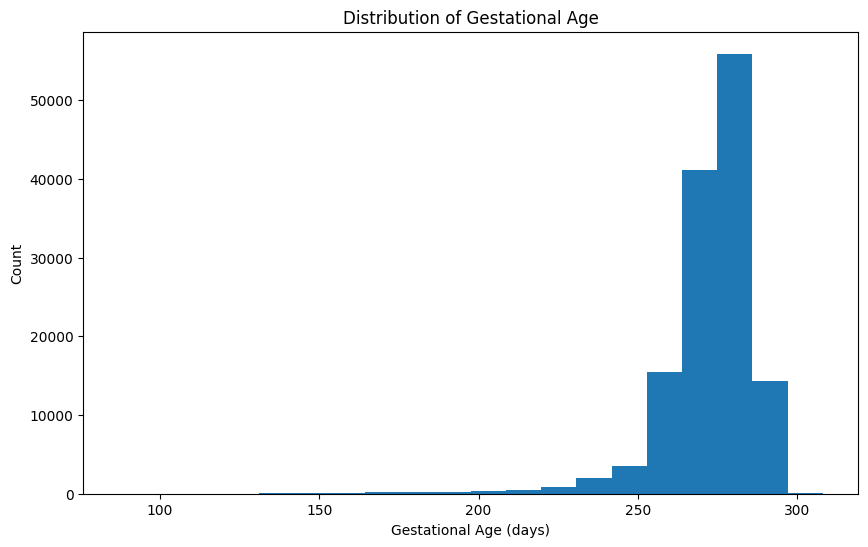

C:\Users\User\AppData\Local\Temp\ipykernel_19544\2166404301.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['gestational_age_bin'] = (df_plot['gestational_age_2052'] // 7).astype(int) * 7


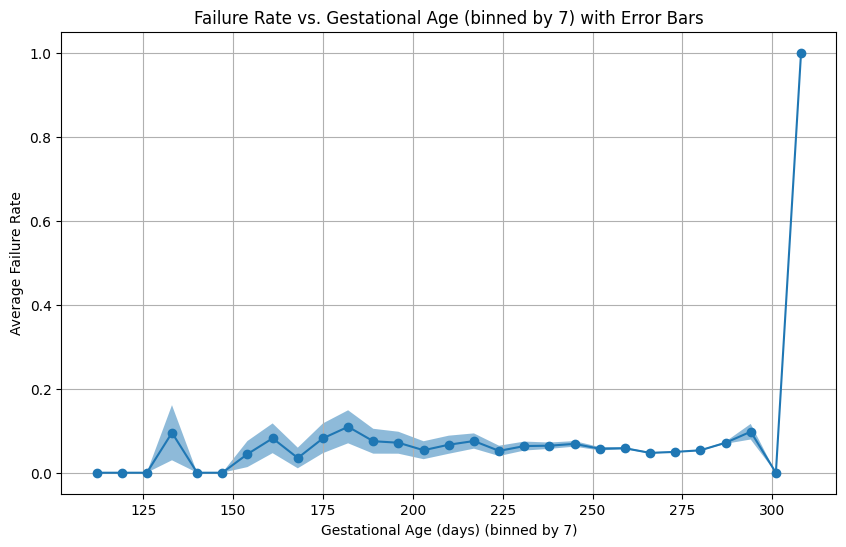

In [48]:
# prompt: do the same but for gestational age

# Histogram of gestational age
plt.figure(figsize=(10, 6))
plt.hist(df['gestational_age_2052'].dropna(), bins=20) # Adjust bins as needed
plt.xlabel('Gestational Age (days)')
plt.ylabel('Count')
plt.title('Distribution of Gestational Age')
plt.show()

# Analyze gestational age in relation to failed catheter
df_plot = neuraxial_catheter_df.dropna(subset=['gestational_age_2052', 'failed_catheter'])
df_plot['gestational_age_bin'] = (df_plot['gestational_age_2052'] // 7).astype(int) * 7
failure_by_gestational_age = df_plot.groupby('gestational_age_bin')['failed_catheter'].agg(['mean', 'sem'])

plt.figure(figsize=(10, 6))
plt.plot(failure_by_gestational_age.index, failure_by_gestational_age['mean'], marker='o')
plt.fill_between(failure_by_gestational_age.index,
                failure_by_gestational_age['mean'] - failure_by_gestational_age['sem'],
                failure_by_gestational_age['mean'] + failure_by_gestational_age['sem'],
                alpha=0.5)
plt.xlabel('Gestational Age (days) (binned by 7)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Gestational Age (binned by 7) with Error Bars')
plt.grid(True)
plt.show()

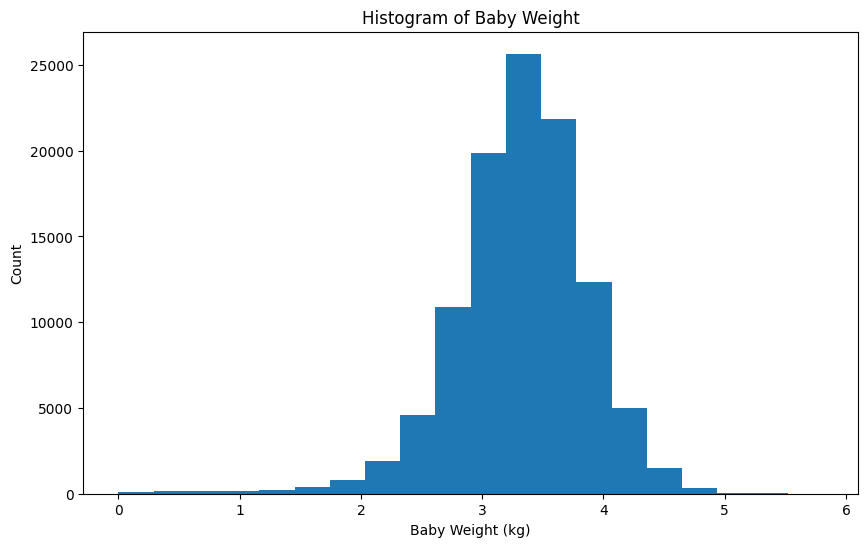

C:\Users\User\AppData\Local\Temp\ipykernel_19544\2857395661.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['baby_weight_bin'] = (df_plot['baby_weight_2196'] // 0.5) * 0.5


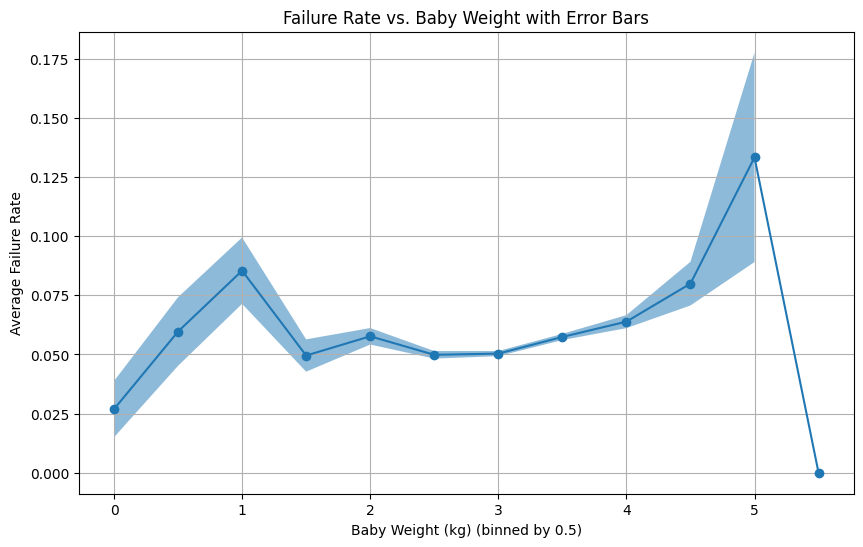

In [49]:
# prompt: do the same histogram and binned failure rate but for baby_weight_2196

# Assuming 'baby_weight_2196' is a column in your DataFrame 'df' or 'neuraxial_catheter_df'
plt.figure(figsize=(10, 6))
plt.hist(neuraxial_catheter_df['baby_weight_2196'].dropna(), bins=20)  # Adjust bins as needed
plt.xlabel('Baby Weight (kg)')
plt.ylabel('Count')
plt.title('Histogram of Baby Weight')
plt.show()

# Assuming 'neuraxial_catheter_df' is your DataFrame

df_plot = neuraxial_catheter_df.dropna(subset=['baby_weight_2196', 'failed_catheter'])

# Bin the baby weight
df_plot['baby_weight_bin'] = (df_plot['baby_weight_2196'] // 0.5) * 0.5

# Group by the binned baby weight and calculate the mean and standard error of the mean of failed_catheter
failure_by_baby_weight = df_plot.groupby('baby_weight_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_baby_weight.index, failure_by_baby_weight['mean'], marker='o')
plt.fill_between(failure_by_baby_weight.index,
                 failure_by_baby_weight['mean'] - failure_by_baby_weight['sem'],
                 failure_by_baby_weight['mean'] + failure_by_baby_weight['sem'],
                 alpha=0.5)  # Add shaded error bars

plt.xlabel('Baby Weight (kg) (binned by 0.5)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Baby Weight with Error Bars')
plt.grid(True)
plt.show()

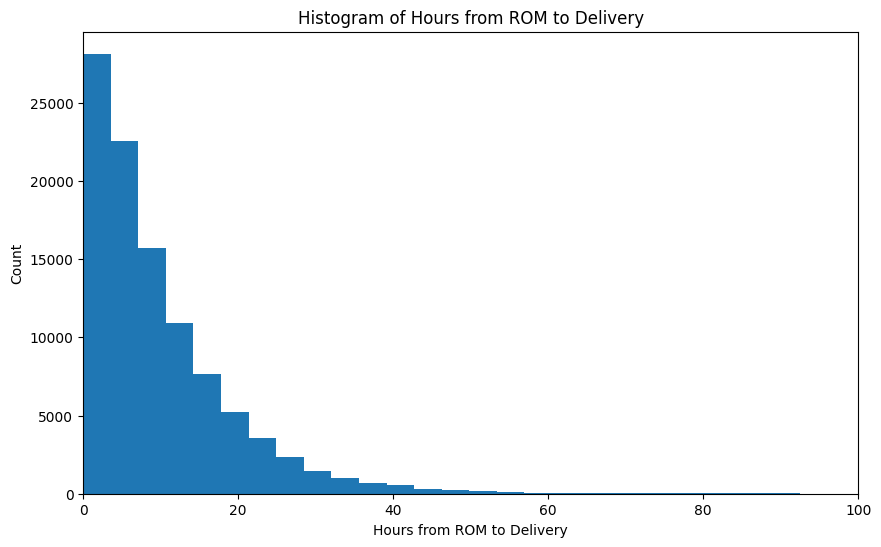

In [50]:
# prompt: do the same count histogram but for secs_rom_thru_delivery_2197

# Assuming 'neuraxial_catheter_df' is your DataFrame

# Drop NaN values in 'secs_rom_thru_delivery_2197'
df_plot = neuraxial_catheter_df.dropna(subset=['rom_thru_delivery_hours'])

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_plot['rom_thru_delivery_hours'], bins=200)  # Adjust bins as needed
plt.xlabel('Hours from ROM to Delivery')
plt.xlim(0,100)
plt.ylabel('Count')
plt.title('Histogram of Hours from ROM to Delivery')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_19544\1238184939.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['rom_thru_delivery_hours_bin'] = (df_plot['rom_thru_delivery_hours'] // 1).astype(int)


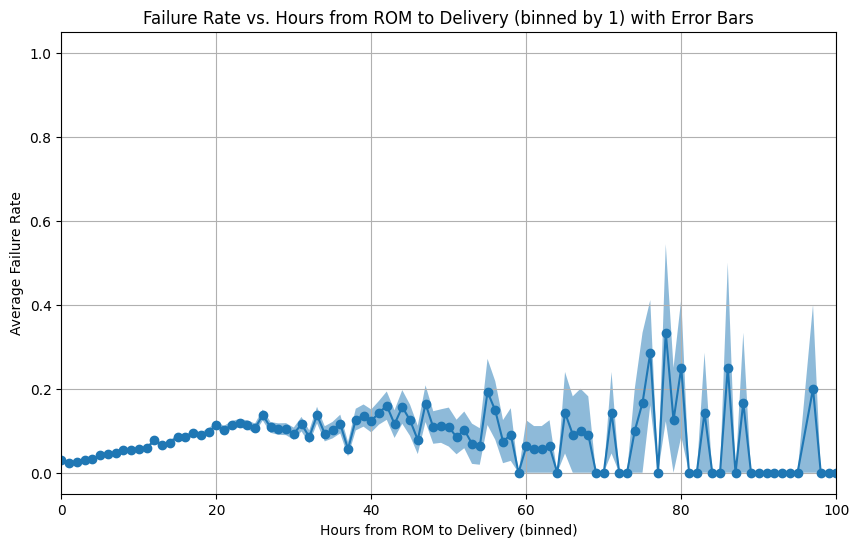

In [51]:
# prompt: do the same binned plot for rom_thru_delivery_hours

# Assuming 'neuraxial_catheter_df' is your DataFrame

df_plot = neuraxial_catheter_df.dropna(subset=['rom_thru_delivery_hours', 'failed_catheter'])

# Bin the rom_thru_delivery_hours
df_plot['rom_thru_delivery_hours_bin'] = (df_plot['rom_thru_delivery_hours'] // 1).astype(int)

# Group by the binned rom_thru_delivery_hours and calculate the mean and standard error of the mean of failed_catheter
failure_by_rom_delivery = df_plot.groupby('rom_thru_delivery_hours_bin')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_by_rom_delivery.index, failure_by_rom_delivery['mean'], marker='o')
plt.fill_between(failure_by_rom_delivery.index,
                 failure_by_rom_delivery['mean'] - failure_by_rom_delivery['sem'],
                 failure_by_rom_delivery['mean'] + failure_by_rom_delivery['sem'],
                 alpha=0.5)  # Add shaded error bars
plt.xlim(0,100)
plt.xlabel('Hours from ROM to Delivery (binned)')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Hours from ROM to Delivery (binned by 1) with Error Bars')
plt.grid(True)
plt.show()

## Prior failed catheters

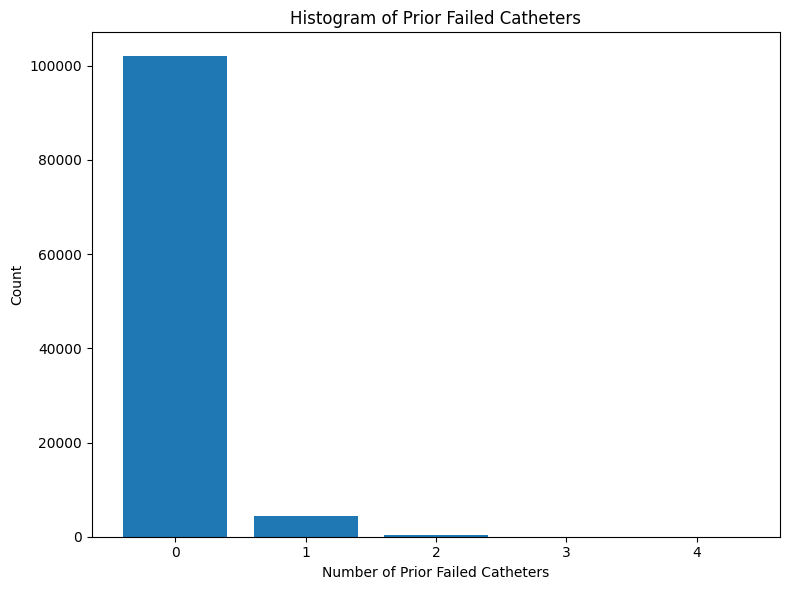

In [52]:
# Assuming 'prior_failed_catheters' is a column in your DataFrame 'neuraxial_catheter_df'
prior_failed_catheters_counts = neuraxial_catheter_df['prior_failed_catheters'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(prior_failed_catheters_counts.index, prior_failed_catheters_counts.values)
plt.xlabel('Number of Prior Failed Catheters')
plt.ylabel('Count')
plt.title('Histogram of Prior Failed Catheters')
plt.xticks(range(int(prior_failed_catheters_counts.index.min()), int(prior_failed_catheters_counts.index.max()) + 1))  # Show only integer ticks on x-axis
plt.tight_layout()
plt.show()

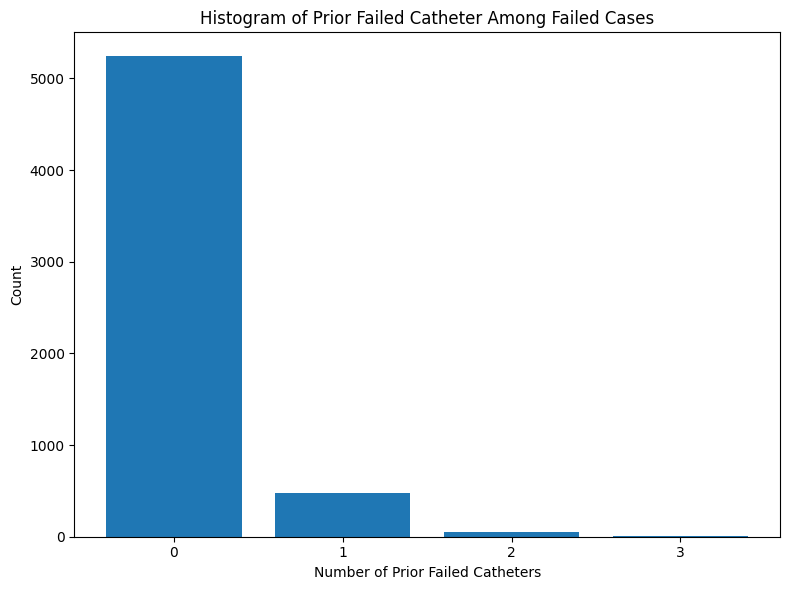

In [53]:
# Assuming 'prior_failed_catheters' is a column in your DataFrame 'neuraxial_catheter_df'
prior_failed_catheters_counts = neuraxial_catheter_df[neuraxial_catheter_df['failed_catheter'] == 1]['prior_failed_catheters'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(prior_failed_catheters_counts.index, prior_failed_catheters_counts.values)
plt.xlabel('Number of Prior Failed Catheters')
plt.ylabel('Count')
plt.title('Histogram of Prior Failed Catheter Among Failed Cases')
plt.xticks(range(int(prior_failed_catheters_counts.index.min()), int(prior_failed_catheters_counts.index.max()) + 1))  # Show only integer ticks on x-axis
plt.tight_layout()
plt.show()

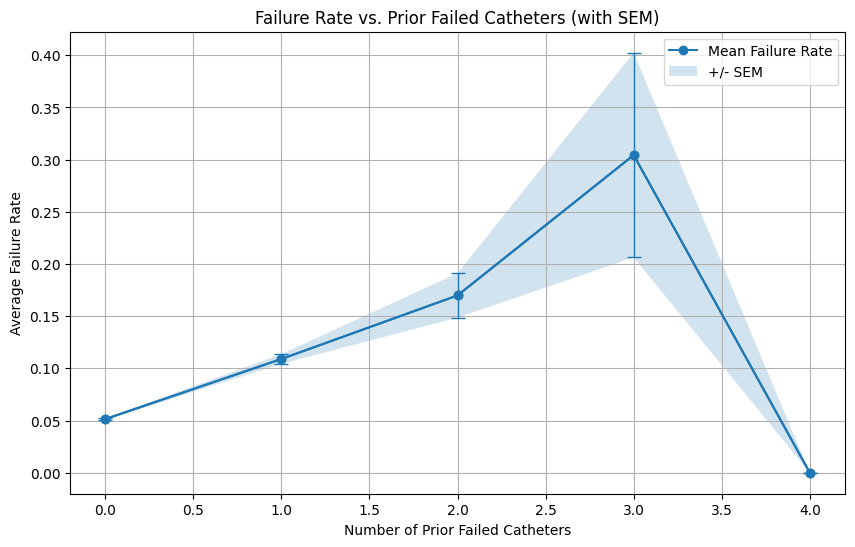

In [54]:

# Drop rows with NaN in 'prior_failed_catheters'
df_plot = neuraxial_catheter_df.dropna(subset=['prior_failed_catheters'])

# Group by 'prior_failed_catheters' and calculate mean + standard error of the mean (sem)
failure_by_prior = df_plot.groupby('prior_failed_catheters')['failed_catheter'].agg(['mean', 'sem'])

# Create the plot with error bars
plt.figure(figsize=(10, 6))
plt.plot(failure_by_prior.index, failure_by_prior['mean'], marker='o', label='Mean Failure Rate')

# Shaded region for +/- SEM
plt.fill_between(failure_by_prior.index,
                 failure_by_prior['mean'] - failure_by_prior['sem'],
                 failure_by_prior['mean'] + failure_by_prior['sem'],
                 alpha=0.2, label='+/- SEM')

# Error bars for SEM
plt.errorbar(failure_by_prior.index,
             failure_by_prior['mean'],
             yerr=failure_by_prior['sem'],
             fmt='o-', capsize=5, elinewidth=1, color='C0') 

plt.xlabel('Number of Prior Failed Catheters')
plt.ylabel('Average Failure Rate')
plt.title('Failure Rate vs. Prior Failed Catheters (with SEM)')
plt.grid(True)
plt.legend()
plt.show()

# Statistical Analysis

## Some individually interesting regressions

In [55]:
df_corr = neuraxial_catheter_df.dropna(subset=['lor_depth', 'number_of_neuraxial_attempts'])

# Fit the model using the formula
model = smf.ols('number_of_neuraxial_attempts ~ lor_depth', data=df_corr).fit()

# Print the summary of the regression results
print(model.summary())


                                 OLS Regression Results                                 
Dep. Variable:     number_of_neuraxial_attempts   R-squared:                       0.042
Model:                                      OLS   Adj. R-squared:                  0.042
Method:                           Least Squares   F-statistic:                     3719.
Date:                          Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                                  22:08:01   Log-Likelihood:                -75199.
No. Observations:                         84127   AIC:                         1.504e+05
Df Residuals:                             84125   BIC:                         1.504e+05
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [56]:
# For categorical variables like DPE and failed_catheter
from scipy.stats import chi2_contingency

dpe_crosstab = pd.crosstab((epidural_df['true_procedure_type_incl_dpe'] == 'dpe').astype(int), epidural_df['failed_catheter'])
chi2, p, _, _ = chi2_contingency(dpe_crosstab)

print(dpe_crosstab.div(dpe_crosstab.sum(axis=1), axis=0) * 100)
print("Chi-squared statistic:", chi2)
print("P-value:", p)

failed_catheter                       0         1
true_procedure_type_incl_dpe                     
0                             94.220570  5.779430
1                             94.736507  5.263493
Chi-squared statistic: 6.374223766208166
P-value: 0.011578967661203544


In [57]:
# prompt: Do univariate logistic regression separately using number of attempts and loss of resistance depth to predict failure

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare the data for logistic regression with number of attempts as the predictor
df_logreg_attempts = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts', 'failed_catheter'])
# Fit the logistic regression model
model_attempts = smf.logit('failed_catheter ~ number_of_neuraxial_attempts', data=df_logreg_attempts).fit()

# Print the summary of the model
print(model_attempts.summary())


# Prepare the data for logistic regression with loss of resistance depth as the predictor
df_logreg_lor = neuraxial_catheter_df.dropna(subset=['lor_depth', 'failed_catheter'])
# Fit the logistic regression model
model_lor = smf.logit('failed_catheter ~ lor_depth', data=df_logreg_lor).fit()

# Print the summary of the model
print(model_lor.summary())


Optimization terminated successfully.
         Current function value: 0.214454
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        failed_catheter   No. Observations:                87138
Model:                          Logit   Df Residuals:                    87136
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                0.001550
Time:                        22:08:02   Log-Likelihood:                -18687.
converged:                       True   LL-Null:                       -18716.
Covariance Type:            nonrobust   LLR p-value:                 2.574e-14
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -3.0580      0.033    -92.945      0.000

In [58]:
# prompt: Now do multivariate analysis using the same two predictors

# Prepare the data for logistic regression with both predictors
df_logreg_multi = neuraxial_catheter_df.dropna(subset=['number_of_neuraxial_attempts', 'lor_depth', 'failed_catheter'])

# Fit the logistic regression model with both predictors
model_multi = smf.logit('failed_catheter ~ number_of_neuraxial_attempts + lor_depth', data=df_logreg_multi).fit()

# Print the summary of the model
print(model_multi.summary())


Optimization terminated successfully.
         Current function value: 0.214449
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        failed_catheter   No. Observations:                84127
Model:                          Logit   Df Residuals:                    84124
Method:                           MLE   Df Model:                            2
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                0.006472
Time:                        22:08:02   Log-Likelihood:                -18041.
converged:                       True   LL-Null:                       -18159.
Covariance Type:            nonrobust   LLR p-value:                 9.158e-52
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -3.8237      0.066    -57.590      0.000

In [59]:
# Prepare the data for logistic regression with prior_failed_catheters as the predictor
df_logreg_prior_failed = neuraxial_catheter_df.dropna(subset=['prior_failed_catheters', 'failed_catheter'])

# Fit the logistic regression model
model_attempts = smf.logit('failed_catheter ~ prior_failed_catheters', data=df_logreg_prior_failed).fit()

# Print the summary of the model
print(model_attempts.summary())

Optimization terminated successfully.
         Current function value: 0.209265
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        failed_catheter   No. Observations:               106750
Model:                          Logit   Df Residuals:                   106748
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                0.006203
Time:                        22:08:02   Log-Likelihood:                -22339.
converged:                       True   LL-Null:                       -22478.
Covariance Type:            nonrobust   LLR p-value:                 1.314e-62
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.9129      0.014   -206.639      0.000      -2.940      

## All univariate regressions

In [60]:

def all_regressions_each_dummy(df, outcome_col='failed_catheter'):
    """
    Fits a univariate logistic regression for each column in df (except outcome_col).
    For numeric columns, you get a single slope term.
    For categorical columns, you get one dummy variable per level (minus the reference).
    Then plots x=coefficient, y=-log10(p-value) for *all* those dummy variables.
    """
    

    results = []

    for col in df.columns:
        # Skip the outcome column
        if col == outcome_col:
            continue

        # Skip encounter_id
        if col == "anes_procedure_encounter_id_2273":
            continue
        
        # Skip datetime or other unsupported types
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            continue
        
        # Subset to non-null rows in outcome & predictor
        temp_df = df[[outcome_col, col]].dropna()
        
        # Skip if not enough variation
        if temp_df[col].nunique() < 2 or temp_df[col].count() < 5:
            continue
        
        # Build formula
        # Wrap in C() if categorical
        if pd.api.types.is_numeric_dtype(temp_df[col]):
            formula = f"{outcome_col} ~ {col}"
        else:
            # # 1. Count frequencies
            # freq_counts = df[col].value_counts()  # returns a Series with counts

            # # 2. Sort them in descending order (most frequent first)
            # freq_order = freq_counts.index.tolist()   # e.g., ['control', 'treatmentA', 'treatmentB']

            # # 3. Reorder categories
            # df[col] = df[col].astype('category')
            # df[col] = df[col].cat.reorder_categories(freq_order, ordered=False)

            # 4. Create the formula

            if col == 'true_procedure_type_incl_dpe':
                formula = f"{outcome_col} ~ C({col}, Treatment(reference='epidural'))"
            else:
                formula = f"{outcome_col} ~ C({col})"
        
        # Fit the logistic model
        try:
            model = smf.logit(formula, data=temp_df).fit(disp=False)
        except Exception as e:
            print(f"Skipping column '{col}' due to fitting error: {e}")
            continue
        
        # For each parameter (except the Intercept),
        # capture the coefficient and p-value.
        for param_name in model.params.index:
            if param_name == 'Intercept':
                continue
            
            coef = model.params.loc[param_name]
            pval = model.pvalues.loc[param_name]
            
            # You might want to create a cleaner label for the parameter.
            # For categorical variables, param_name will look like 'C(col)[T.level]'
            # We'll store the raw param_name, but you can parse it if you like.

            results.append({
                'column': col,
                'param_name': param_name,
                'coef': coef,
                'pval': pval
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    if results_df.empty:
        print("No valid predictors found.")
        return pd.DataFrame()

    # Sort by p-value (optional)
    results_df = results_df.sort_values(by='pval')

    
    return results_df


# Example usage:
results_df = all_regressions_each_dummy(neuraxial_catheter_df, 'failed_catheter')
# This returns a DataFrame with columns: [column, param_name, coef, pval].
# Each level of a categorical predictor will appear as a separate row.

In [61]:

import re

def parse_param_name(param_name):
    """
    Parses a statsmodels parameter name like:
        'C(col)[T.value]'
    and returns the level name 'value'.
    """
    
    # Regex for the typical pattern: C(colName)[T.levelName]
    pattern = r'.*\[T\.(.+)\]'
    match = re.match(pattern, param_name)
    if match:
        level_name = match.group(1)
        return level_name
    # If it doesn't match, assume it's some other type of parameter (e.g., numeric var)
    return ''


In [62]:
results_df['category_variable'] = results_df['param_name'].apply(parse_param_name)

In [63]:
results_df

,column,param_name,coef,pval,category_variable
2,delivery_site_2188,C(delivery_site_2188)[T.mgh],0.842643,1.715852e-139,mgh
21,bmi_end_pregnancy_2044,bmi_end_pregnancy_2044,0.038101,2.595455e-77,
52,prior_failed_catheters,prior_failed_catheters,0.751188,3.729001e-77,
22,maternal_weight_end_pregnancy_2045,maternal_weight_end_pregnancy_2045,0.011855,4.508935e-61,
19,fetal_presentation_position_2247,C(fetal_presentation_position_2247)[T.posterior],0.803894,2.399477e-55,posterior
26,lor_depth,lor_depth,0.149341,3.297959e-51,
25,parity_2048,parity_2048,-0.345796,1.660724e-49,
9,rom_thru_delivery_hours,rom_thru_delivery_hours,0.005540,4.543329e-43,
42,composite_psychosocial_problems,composite_psychosocial_problems,0.365990,3.698568e-38,
41,prior_pain_scores_max,prior_pain_scores_max,0.006658,1.026158e-34,


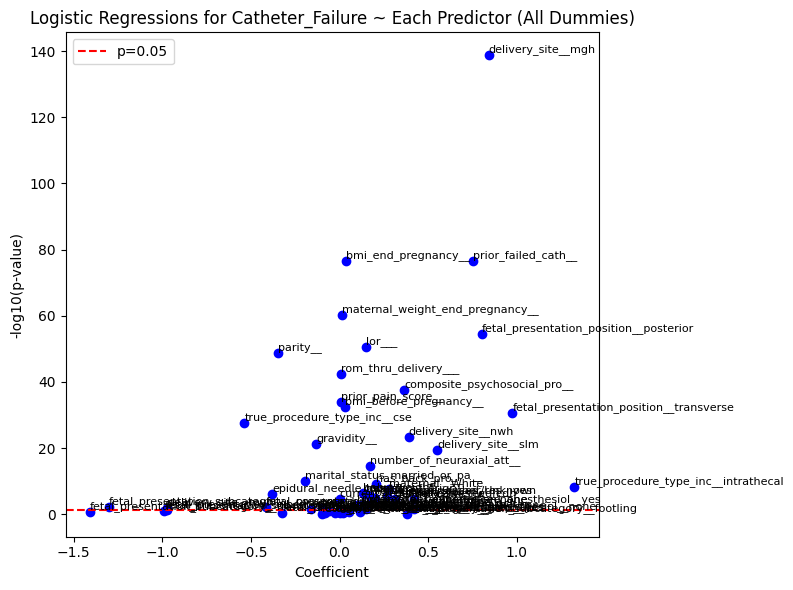

In [64]:

# Create plot: coefficient vs -log10(p-value)
fig, ax = plt.subplots(figsize=(8, 6))

offset = 1e-300  # so we don't take log10(0)
x_vals = results_df[results_df['pval'] < 0.9]['coef']
y_vals = -np.log10(results_df[results_df['pval'] < 0.9]['pval'] + offset)

sc = ax.scatter(x_vals, y_vals, color='blue')

# Annotate each point
for i, row in results_df[results_df['pval'] < 0.9].iterrows():
    ax.text(
        row['coef'],
        -np.log10(row['pval'] + offset),
        str(row['column'][:-5] + '__' + str(row['category_variable'])),
        fontsize=8,
        ha='left',
        va='bottom'
    )

# Add a reference line for p=0.05
ax.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')

ax.set_xlabel('Coefficient')
ax.set_ylabel('-log10(p-value)')
ax.set_title(f'Logistic Regressions for Catheter_Failure ~ Each Predictor (All Dummies)')
ax.legend()

plt.tight_layout()
plt.show()


# Logistic Regression Model

In [65]:
# Filter the DataFrame to include only neuraxial catheter (ie, epidural + CSE + intrathecal) procedures
neuraxial_catheter_df = df[df['is_neuraxial_catheter'] == 1]

### Random data for model comparison

In [66]:
test_dataset = pd.DataFrame()
test_dataset['failed_catheter'] = neuraxial_catheter_df['failed_catheter']
test_dataset['anes_procedure_encounter_id_2273'] = neuraxial_catheter_df['anes_procedure_encounter_id_2273']
test_dataset['random_feature_1'] = np.random.rand(len(test_dataset))
test_dataset['random_feature_2'] = np.random.rand(len(test_dataset))

In [67]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Load the dataset
data = test_dataset

# Drop columns with more than 80% missing values
threshold = len(data) * 0.2
data_cleaned = data.dropna(thresh=threshold, axis=1)

# Drop rows where target variable is missing
data_cleaned = data_cleaned.dropna(subset=["failed_catheter"])

# Separate features and target variable
X = data_cleaned.drop(columns=["failed_catheter", "best_timestamp"], errors='ignore')
y = data_cleaned["failed_catheter"]

##############################################################################
# 1. Extract the group labels and remove them from X if it's just an ID column
##############################################################################
groups = X['anes_procedure_encounter_id_2273']  # Save group labels
# If you do NOT want to use `anes_procedure_encounter_id_2273` as a feature:
X = X.drop(columns=["anes_procedure_encounter_id_2273"])  

##############################################################################
# 2. Split using GroupShuffleSplit instead of train_test_split
##############################################################################
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train logistic regression with class weights
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', n_jobs=1)
logistic_model.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test_preprocessed)
y_pred_prob = logistic_model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate the model
evaluation_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_prob),
    "classification_report": classification_report(y_test, y_pred)
}

# Print evaluation metrics
print("TEST RANDOM Model Evaluation:")
for metric, value in evaluation_metrics.items():
    if metric == "classification_report":
        print("\nTEST RANDOM Classification Report:\n", value)
    else:
        print(f"{metric.capitalize()}: {value:.4f}")


TEST RANDOM Model Evaluation:
Accuracy: 0.5020
Precision: 0.0533
Recall: 0.5004
Roc_auc: 0.5013

TEST RANDOM Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.50      0.66     20201
           1       0.05      0.50      0.10      1131

    accuracy                           0.50     21332
   macro avg       0.50      0.50      0.38     21332
weighted avg       0.90      0.50      0.63     21332



### Real logistic regression

In [68]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Load the dataset
data = neuraxial_catheter_df

# Drop columns with more than 80% missing values
threshold = len(data) * 0.2
data_cleaned = data.dropna(thresh=threshold, axis=1)

# Drop rows where target variable is missing
data_cleaned = data_cleaned.dropna(subset=["failed_catheter"])

# Separate features and target variable
X = data_cleaned.drop(columns=["failed_catheter", "best_timestamp"], errors='ignore')
y = data_cleaned["failed_catheter"]


## Drop delivery_site_2188
# X = X.drop(columns=["delivery_site_2188"],errors='ignore')

##############################################################################
# 1. Extract the group labels and remove them from X if it's just an ID column
##############################################################################
groups = X['anes_procedure_encounter_id_2273']  # Save group labels
# If you do NOT want to use `anes_procedure_encounter_id_2273` as a feature:
X = X.drop(columns=["anes_procedure_encounter_id_2273"])  

##############################################################################
# 2. Split using GroupShuffleSplit instead of train_test_split
##############################################################################
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train logistic regression with class weights
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', n_jobs=1)
logistic_model.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test_preprocessed)
y_pred_prob = logistic_model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate the model
evaluation_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_prob),
    "classification_report": classification_report(y_test, y_pred)
}

# Print evaluation metrics
print("Model Evaluation:")
for metric, value in evaluation_metrics.items():
    if metric == "classification_report":
        print("\nClassification Report:\n", value)
    else:
        print(f"{metric.capitalize()}: {value:.4f}")


Model Evaluation:
Accuracy: 0.6583
Precision: 0.0906
Recall: 0.6021
Roc_auc: 0.6819

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.66      0.79     20201
           1       0.09      0.60      0.16      1131

    accuracy                           0.66     21332
   macro avg       0.53      0.63      0.47     21332
weighted avg       0.92      0.66      0.75     21332



In [69]:
# 1. Get the feature names produced by the ColumnTransformer
feature_names = preprocessor.get_feature_names_out()

# 2. Get the coefficients from the trained logistic model
#    For binary classification, .coef_ is an array of shape (1, n_features)
coefficients = logistic_model.coef_[0]

# 3. Combine feature names with coefficients into a list of tuples
coef_pairs = list(zip(feature_names, coefficients))

# 4. Sort by absolute coefficient value in descending order
coef_pairs_sorted = sorted(coef_pairs, key=lambda x: abs(x[1]), reverse=True)

# 5. Print the sorted coefficients
print("Coefficients for each feature (sorted by absolute magnitude):")
for name, coef in coef_pairs_sorted:
    print(f"  {name}: {coef:.4f}")

# 6. Print the intercept
print(f"Intercept: {logistic_model.intercept_[0]:.4f}")


Coefficients for each feature (sorted by absolute magnitude):
  cat__true_procedure_type_incl_dpe_intrathecal: 1.2498
  cat__delivery_site_2188_mvh: -1.1765
  cat__true_procedure_type_incl_dpe_cse: -0.7646
  cat__fetal_presentation_subcategory_2244_frank: -0.7492
  cat__delivery_site_2188_mgh: 0.6712
  cat__fetal_presentation_subcategory_2244_brow: 0.5990
  cat__fetal_presentation_subcategory_2244_footling: 0.5106
  cat__fetal_presentation_category_2243_breech: 0.3647
  num__rom_thru_delivery_hours: 0.3503
  cat__fetal_presentation_subcategory_2244_face: 0.3138
  cat__fetal_presentation_position_2247_anterior: -0.2929
  cat__fetal_presentation_category_2243_compound: -0.2871
  cat__fetal_presentation_subcategory_2244_compound: -0.2871
  cat__fetal_presentation_subcategory_2244_vertex: -0.2850
  cat__delivery_site_2188_nwh: 0.2747
  cat__delivery_site_2188_nch: 0.2698
  cat__fetal_presentation_position_2247_transverse: 0.2689
  cat__delivery_site_2188_bwh: -0.2298
  cat__delivery_site_2

# XGBoost

In [70]:
##############################################################################
# Imports
##############################################################################
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Import XGBoost
from xgboost import XGBClassifier

##############################################################################
# 0. Load and prepare the dataset
##############################################################################
data = neuraxial_catheter_df

# Drop columns with more than 80% missing values
threshold = len(data) * 0.2
data_cleaned = data.dropna(thresh=threshold, axis=1)

# Drop rows where target variable is missing
data_cleaned = data_cleaned.dropna(subset=["failed_catheter"])

# Separate features and target variable
X = data_cleaned.drop(columns=["failed_catheter", "best_timestamp"], errors='ignore')
y = data_cleaned["failed_catheter"]

# # Drop delivery_site_2188
# X = X.drop(columns=["delivery_site_2188"],errors='ignore')

##############################################################################
# 1. Extract the group labels and remove them from X if it's just an ID column
##############################################################################
groups = X['anes_procedure_encounter_id_2273']  # Save group labels
X = X.drop(columns=["anes_procedure_encounter_id_2273"])  # remove ID column from features

##############################################################################
# 2. Split using GroupShuffleSplit instead of train_test_split
##############################################################################
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

##############################################################################
# 3. Identify numeric and categorical columns
##############################################################################
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

##############################################################################
# 4. Create preprocessing pipelines
##############################################################################
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

##############################################################################
# 5. Preprocess the data
##############################################################################
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

##############################################################################
# 6. Train XGBoost Classifier
##############################################################################
# Instantiate the XGBClassifier
# Note: You can tune parameters such as 'scale_pos_weight' if your data is imbalanced.
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train.shape[0] - y_train.sum()) / y_train.sum()
)
xgb_model.fit(X_train_preprocessed, y_train)

##############################################################################
# 7. Make predictions
##############################################################################
y_pred = xgb_model.predict(X_test_preprocessed)
y_pred_prob = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

##############################################################################
# 8. Evaluate the model
##############################################################################
evaluation_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_prob),
    "classification_report": classification_report(y_test, y_pred)
}

##############################################################################
# 9. Print the evaluation metrics
##############################################################################
print("Model Evaluation:")
for metric, value in evaluation_metrics.items():
    if metric == "classification_report":
        print("\nClassification Report:\n", value)
    else:
        print(f"{metric.capitalize()}: {value:.4f}")


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\xgboost\core.py:158: UserWarning: [22:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Evaluation:
Accuracy: 0.7876
Precision: 0.1032
Recall: 0.3908
Roc_auc: 0.6517

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     20201
           1       0.10      0.39      0.16      1131

    accuracy                           0.79     21332
   macro avg       0.53      0.60      0.52     21332
weighted avg       0.91      0.79      0.84     21332



# Propensity Scoring for DPE

In [71]:
import pandas as pd
import numpy as np

# For logistic regression and nearest neighbor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# For imputation and scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# For statistical inference (CIs, p-values)
import statsmodels.api as sm

# ------------------------------------------------------------------------------
# 1. Copy your original dataframe
# ------------------------------------------------------------------------------
df = epidural_df.copy()
df['dpe'] = (df['true_procedure_type_incl_dpe'] == 'dpe').astype(int)
df.drop(columns=['true_procedure_type_incl_dpe'], inplace=True)

# Columns for the treatment and outcome
treatment_col = 'dpe'
outcome_col   = 'failed_catheter'

# ------------------------------------------------------------------------------
# 2. Identify numeric vs. categorical columns (excluding treatment & outcome)
# ------------------------------------------------------------------------------
# If 'dpe' or 'failed_catheter' happen to be numeric, we still exclude them from imputation.
numeric_cols = [
    col for col in df.select_dtypes(include=[np.number]).columns
    if col not in [treatment_col, outcome_col]
]
categorical_cols = [
    col for col in df.columns
    if col not in numeric_cols and col not in [treatment_col, outcome_col]
]

# ------------------------------------------------------------------------------
# 3. Impute missing data
#    - Median for numeric
#    - Most frequent for categorical
# ------------------------------------------------------------------------------
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit/transform numeric columns
df_num = pd.DataFrame(
    num_imputer.fit_transform(df[numeric_cols]),
    columns=numeric_cols
)

# Fit/transform categorical columns
df_cat = pd.DataFrame(
    cat_imputer.fit_transform(df[categorical_cols]),
    columns=categorical_cols
)

# ------------------------------------------------------------------------------
# 4. One-hot encode (dummy) the categorical columns
# ------------------------------------------------------------------------------
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)

# ------------------------------------------------------------------------------
# 5. Combine imputed numeric + encoded categorical with original treatment/outcome
# ------------------------------------------------------------------------------
# Reattach treatment/outcome columns to the front, for convenience
df_imputed = pd.concat(
    [
        df[[treatment_col, outcome_col]].reset_index(drop=True),
        df_num.reset_index(drop=True),
        df_cat_encoded.reset_index(drop=True)
    ],
    axis=1
)

# ------------------------------------------------------------------------------
# 6. Standardize numeric features (optional but often recommended)
#    Identify which columns in df_num still exist in df_imputed
# ------------------------------------------------------------------------------
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(
    scaler.fit_transform(df_imputed[numeric_cols]),
    columns=numeric_cols
)

# Now replace the unscaled numeric columns in df_imputed
for col in numeric_cols:
    df_imputed[col] = df_num_scaled[col]

# ------------------------------------------------------------------------------
# 7. Fit the propensity model (LogisticRegression) on all columns except
#    the treatment and outcome columns.
# ------------------------------------------------------------------------------
feature_cols = [c for c in df_imputed.columns if c not in [treatment_col, outcome_col]]

X = df_imputed[feature_cols].values  # all imputed & encoded features
y = df_imputed[treatment_col].values # the treatment indicator (dpe)

propensity_model = LogisticRegression(solver='lbfgs', max_iter=1000)
propensity_model.fit(X, y)

# Probability of dpe=1
propensity_scores = propensity_model.predict_proba(X)[:, 1]
df_imputed['propensity_score'] = propensity_scores

# ------------------------------------------------------------------------------
# 8. Separate treated vs. control and do nearest-neighbor matching
# ------------------------------------------------------------------------------
treated = df_imputed[df_imputed[treatment_col] == 1].copy()
control = df_imputed[df_imputed[treatment_col] == 0].copy()

treated_scores = treated[['propensity_score']].values
control_scores = control[['propensity_score']].values

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(control_scores)

distances, indices = nn.kneighbors(treated_scores)
distances = distances.flatten()
indices = indices.flatten()

matched_treated = treated.copy()
matched_control = control.iloc[indices].copy()

# Combine matched sample
matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

# ------------------------------------------------------------------------------
# 9. Fit an outcome model on the matched sample
#    We'll use statsmodels for confidence intervals and p-values.
# ------------------------------------------------------------------------------
matched_data['intercept'] = 1.0

# We'll just use dpe (and intercept) in the outcome model here
X_outcome = matched_data[['intercept', treatment_col]]
y_outcome = matched_data[outcome_col]

logit_sm = sm.Logit(y_outcome, X_outcome)
result_sm = logit_sm.fit(disp=0)  # disp=0 hides optimization output

print(result_sm.summary())

# Extract OR & 95% CI
params = result_sm.params
conf = result_sm.conf_int()
odds_ratios = np.exp(params)
conf_odds = np.exp(conf)

print("\nOdds Ratios:\n", odds_ratios)
print("\n95% Confidence Intervals:\n", conf_odds)


                           Logit Regression Results                           
Dep. Variable:        failed_catheter   No. Observations:                31424
Model:                          Logit   Df Residuals:                    31422
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                0.003058
Time:                        22:08:15   Log-Likelihood:                -7253.8
converged:                       True   LL-Null:                       -7276.1
Covariance Type:            nonrobust   LLR p-value:                 2.539e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.5758      0.031    -82.766      0.000      -2.637      -2.515
dpe           -0.3145      0.047     -6.637      0.000      -0.407      -0.222

Odds Ratios:
 intercept    0.076091
dpe          0.

# Propensity Scoring for CSE

In [72]:
import pandas as pd
import numpy as np

# For logistic regression and nearest neighbor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# For imputation and scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# For statistical inference (CIs, p-values)
import statsmodels.api as sm

# ------------------------------------------------------------------------------
# 1. Copy your original dataframe
# ------------------------------------------------------------------------------
df = neuraxial_catheter_df.copy()
df['cse'] = (df['true_procedure_type_incl_dpe'] == 'cse').astype(int)
df.drop(columns=['true_procedure_type_incl_dpe'], inplace=True)

# Columns for the treatment and outcome
treatment_col = 'cse'
outcome_col   = 'failed_catheter'

# ------------------------------------------------------------------------------
# 2. Identify numeric vs. categorical columns (excluding treatment & outcome)
# ------------------------------------------------------------------------------
# If 'dpe' or 'failed_catheter' happen to be numeric, we still exclude them from imputation.
numeric_cols = [
    col for col in df.select_dtypes(include=[np.number]).columns
    if col not in [treatment_col, outcome_col]
]
categorical_cols = [
    col for col in df.columns
    if col not in numeric_cols and col not in [treatment_col, outcome_col]
]

# ------------------------------------------------------------------------------
# 3. Impute missing data
#    - Median for numeric
#    - Most frequent for categorical
# ------------------------------------------------------------------------------
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit/transform numeric columns
df_num = pd.DataFrame(
    num_imputer.fit_transform(df[numeric_cols]),
    columns=numeric_cols
)

# Fit/transform categorical columns
df_cat = pd.DataFrame(
    cat_imputer.fit_transform(df[categorical_cols]),
    columns=categorical_cols
)

# ------------------------------------------------------------------------------
# 4. One-hot encode (dummy) the categorical columns
# ------------------------------------------------------------------------------
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)

# ------------------------------------------------------------------------------
# 5. Combine imputed numeric + encoded categorical with original treatment/outcome
# ------------------------------------------------------------------------------
# Reattach treatment/outcome columns to the front, for convenience
df_imputed = pd.concat(
    [
        df[[treatment_col, outcome_col]].reset_index(drop=True),
        df_num.reset_index(drop=True),
        df_cat_encoded.reset_index(drop=True)
    ],
    axis=1
)

# ------------------------------------------------------------------------------
# 6. Standardize numeric features (optional but often recommended)
#    Identify which columns in df_num still exist in df_imputed
# ------------------------------------------------------------------------------
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(
    scaler.fit_transform(df_imputed[numeric_cols]),
    columns=numeric_cols
)

# Now replace the unscaled numeric columns in df_imputed
for col in numeric_cols:
    df_imputed[col] = df_num_scaled[col]

# ------------------------------------------------------------------------------
# 7. Fit the propensity model (LogisticRegression) on all columns except
#    the treatment and outcome columns.
# ------------------------------------------------------------------------------
feature_cols = [c for c in df_imputed.columns if c not in [treatment_col, outcome_col]]

X = df_imputed[feature_cols].values  # all imputed & encoded features
y = df_imputed[treatment_col].values # the treatment indicator (dpe)

propensity_model = LogisticRegression(solver='lbfgs', max_iter=1000)
propensity_model.fit(X, y)

# Probability of dpe=1
propensity_scores = propensity_model.predict_proba(X)[:, 1]
df_imputed['propensity_score'] = propensity_scores

# ------------------------------------------------------------------------------
# 8. Separate treated vs. control and do nearest-neighbor matching
# ------------------------------------------------------------------------------
treated = df_imputed[df_imputed[treatment_col] == 1].copy()
control = df_imputed[df_imputed[treatment_col] == 0].copy()

treated_scores = treated[['propensity_score']].values
control_scores = control[['propensity_score']].values

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(control_scores)

distances, indices = nn.kneighbors(treated_scores)
distances = distances.flatten()
indices = indices.flatten()

matched_treated = treated.copy()
matched_control = control.iloc[indices].copy()

# Combine matched sample
matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

# ------------------------------------------------------------------------------
# 9. Fit an outcome model on the matched sample
#    We'll use statsmodels for confidence intervals and p-values.
# ------------------------------------------------------------------------------
matched_data['intercept'] = 1.0

# We'll just use dpe (and intercept) in the outcome model here
X_outcome = matched_data[['intercept', treatment_col]]
y_outcome = matched_data[outcome_col]

logit_sm = sm.Logit(y_outcome, X_outcome)
result_sm = logit_sm.fit(disp=0)  # disp=0 hides optimization output

print(result_sm.summary())

# Extract OR & 95% CI
params = result_sm.params
conf = result_sm.conf_int()
odds_ratios = np.exp(params)
conf_odds = np.exp(conf)

print("\nOdds Ratios:\n", odds_ratios)
print("\n95% Confidence Intervals:\n", conf_odds)

del df

                           Logit Regression Results                           
Dep. Variable:        failed_catheter   No. Observations:                27964
Model:                          Logit   Df Residuals:                    27962
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                 0.01260
Time:                        22:08:18   Log-Likelihood:                -5472.0
converged:                       True   LL-Null:                       -5541.9
Covariance Type:            nonrobust   LLR p-value:                 3.118e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.6636      0.034    -77.732      0.000      -2.731      -2.596
cse           -0.6646      0.058    -11.544      0.000      -0.777      -0.552

Odds Ratios:
 intercept    0.069696
cse          0.

# Propensity scoring for DPE vs CSE

In [73]:
import pandas as pd
import numpy as np

# For logistic regression and nearest neighbor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# For imputation and scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# For statistical inference (CIs, p-values)
import statsmodels.api as sm

# ------------------------------------------------------------------------------
# 1. Copy your original dataframe
# ------------------------------------------------------------------------------
df = neuraxial_catheter_df.copy()
df = df[df['true_procedure_type_incl_dpe'].isin(['cse', 'dpe'])]
df['cse_not_dpe'] = (df['true_procedure_type_incl_dpe'] == 'cse').astype(int)
df.drop(columns=['true_procedure_type_incl_dpe'], inplace=True)

# Columns for the treatment and outcome
treatment_col = 'cse_not_dpe'
outcome_col   = 'failed_catheter'

# ------------------------------------------------------------------------------
# 2. Identify numeric vs. categorical columns (excluding treatment & outcome)
# ------------------------------------------------------------------------------
# If 'dpe' or 'failed_catheter' happen to be numeric, we still exclude them from imputation.
numeric_cols = [
    col for col in df.select_dtypes(include=[np.number]).columns
    if col not in [treatment_col, outcome_col]
]
categorical_cols = [
    col for col in df.columns
    if col not in numeric_cols and col not in [treatment_col, outcome_col]
]

# ------------------------------------------------------------------------------
# 3. Impute missing data
#    - Median for numeric
#    - Most frequent for categorical
# ------------------------------------------------------------------------------
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit/transform numeric columns
df_num = pd.DataFrame(
    num_imputer.fit_transform(df[numeric_cols]),
    columns=numeric_cols
)

# Fit/transform categorical columns
df_cat = pd.DataFrame(
    cat_imputer.fit_transform(df[categorical_cols]),
    columns=categorical_cols
)

# ------------------------------------------------------------------------------
# 4. One-hot encode (dummy) the categorical columns
# ------------------------------------------------------------------------------
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)

# ------------------------------------------------------------------------------
# 5. Combine imputed numeric + encoded categorical with original treatment/outcome
# ------------------------------------------------------------------------------
# Reattach treatment/outcome columns to the front, for convenience
df_imputed = pd.concat(
    [
        df[[treatment_col, outcome_col]].reset_index(drop=True),
        df_num.reset_index(drop=True),
        df_cat_encoded.reset_index(drop=True)
    ],
    axis=1
)

# ------------------------------------------------------------------------------
# 6. Standardize numeric features (optional but often recommended)
#    Identify which columns in df_num still exist in df_imputed
# ------------------------------------------------------------------------------
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(
    scaler.fit_transform(df_imputed[numeric_cols]),
    columns=numeric_cols
)

# Now replace the unscaled numeric columns in df_imputed
for col in numeric_cols:
    df_imputed[col] = df_num_scaled[col]

# ------------------------------------------------------------------------------
# 7. Fit the propensity model (LogisticRegression) on all columns except
#    the treatment and outcome columns.
# ------------------------------------------------------------------------------
feature_cols = [c for c in df_imputed.columns if c not in [treatment_col, outcome_col]]

X = df_imputed[feature_cols].values  # all imputed & encoded features
y = df_imputed[treatment_col].values # the treatment indicator (dpe)

propensity_model = LogisticRegression(solver='lbfgs', max_iter=1000)
propensity_model.fit(X, y)

# Probability of dpe=1
propensity_scores = propensity_model.predict_proba(X)[:, 1]
df_imputed['propensity_score'] = propensity_scores

# ------------------------------------------------------------------------------
# 8. Separate treated vs. control and do nearest-neighbor matching
# ------------------------------------------------------------------------------
treated = df_imputed[df_imputed[treatment_col] == 1].copy()
control = df_imputed[df_imputed[treatment_col] == 0].copy()

treated_scores = treated[['propensity_score']].values
control_scores = control[['propensity_score']].values

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(control_scores)

distances, indices = nn.kneighbors(treated_scores)
distances = distances.flatten()
indices = indices.flatten()

matched_treated = treated.copy()
matched_control = control.iloc[indices].copy()

# Combine matched sample
matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

# ------------------------------------------------------------------------------
# 9. Fit an outcome model on the matched sample
#    We'll use statsmodels for confidence intervals and p-values.
# ------------------------------------------------------------------------------
matched_data['intercept'] = 1.0

# We'll just use dpe (and intercept) in the outcome model here
X_outcome = matched_data[['intercept', treatment_col]]
y_outcome = matched_data[outcome_col]

logit_sm = sm.Logit(y_outcome, X_outcome)
result_sm = logit_sm.fit(disp=0)  # disp=0 hides optimization output

print(result_sm.summary())

# Extract OR & 95% CI
params = result_sm.params
conf = result_sm.conf_int()
odds_ratios = np.exp(params)
conf_odds = np.exp(conf)

print("\nOdds Ratios:\n", odds_ratios)
print("\n95% Confidence Intervals:\n", conf_odds)

del df

                           Logit Regression Results                           
Dep. Variable:        failed_catheter   No. Observations:                27964
Model:                          Logit   Df Residuals:                    27962
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                 0.01203
Time:                        22:08:18   Log-Likelihood:                -5437.3
converged:                       True   LL-Null:                       -5503.5
Covariance Type:            nonrobust   LLR p-value:                 1.227e-30
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.6790      0.034    -77.659      0.000      -2.747      -2.611
cse_not_dpe    -0.6492      0.058    -11.250      0.000      -0.762      -0.536

Odds Ratios:
 intercept      0.068633
cse_not_d

# Next Steps

XGBoost - hyperparameter tuning with Optuna

Shapley values for interpretability

Eliminate features that are both poorly predictive and have lots of missing data

Abstract functions and separate them into different files

Fewer features will improve interpretability